In [ ]:
import plot_functions as pf
import numpy as np
from   scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import importlib

ModuleNotFoundError: No module named 'computing_functions'

### ***Implémentation du Modèle Cinétique de X.Colin et al. 2009 (PE/DOC)***

    Cette section détaille l'implémentation en Python du modèle cinétique proposé par Colin et ses collaborateurs pour décrire la dégradation oxydative du Polyéthylène (PE) en présence de Dioxyde de Chlore (DOC). Le modèle repose sur un couplage complexe entre les phénomènes de diffusion des espèces réactives et les réactions chimiques au sein de la paroi du matériau.

**1 - Paramètres d'Entrée Clés :**

    *Propriétés du Matériau PE :*
        L, nz, Mw₀, ρ, [PH]₀, [AH]₀, ti0_oit, [POOH]₀, Xc

    *Conditions Opératoires :*
        T, [DOC]_eau, t_final

    *Paramètres Cinétiques et de Transport (fonction de la température) :*
        k_i(T), D_i(T), β_i(T), γ_i

**2 - Loi de Comportement Réaction-Diffusion (Niveau 1 :) :**

    Système de 12 équations différentielles partielles (EDP) couplées décrivant l'évolution spatio-temporelle Cᵢ(z,t) de chaque espèce chimique i :

        *∂Cᵢ / ∂t = Dᵢ ⋅ ∂²Cᵢ / ∂z² + R(Cᵢ)*

    où R est le terme source chimique (somme des vitesses des réactions produisant ou consommant l'espèce i).

**3 - Conditions Initiales (à t=0) :**

    Profils de concentration initiaux uniformes pour PH, AH, POOH, O₂.

    Concentrations nulles pour DOC (dans la masse), radicaux et autres produits de dégradation.

**4 - Conditions aux Limites (pour t > 0, aux interfaces z=0 et z=L) :**
    
    *4.1- Cas tuyau (epaisseur = 4.5mm):*

        O₂ et DOC (z=0, interface eau/PE) : Concentrations fixes (Dirichlet), imposées par l'équilibre avec le milieu externe.

        DOC (z=L, interface air/PE) : Flux nul (Neumann : ∂[DOC]/∂z = 0) + réactions.

        AH (z=0 et z=L) : Flux d'extraction/évaporation (Robin : J_AH = -β[AH]) + réactions.

        Espèces immobiles : Évolution uniquement par réactions chimiques aux frontières.

    *4.2- Cas film (epaisseur = 0.4mm):*

        O₂ et DOC (z=0 et z=L, interface eau/PE) : Concentrations fixes (Dirichlet), imposées par l'équilibre avec le milieu externe.
        
        AH (z=0 et z=L) : Flux d'extraction (Robin : J_AH = -β[AH]) + réactions (β0=βL).

**5 - Conséquences de la Dégradation Chimique (Niveau 2) :**

    Accumulation de produits d'oxydation (ex: Carbonyles, [CO]).

    Génération de scissions de chaînes (S) et de réticulations (X).

    Modification de la Masse Molaire Moyenne en Poids (Mw(z,t)) calculée via les Équations de Saito à partir de S et X.

### ***Implémentation d'une classe nommée colinPEDegradationModel***

        *NB: some of the plotting functions are defined inside the class as methods, others are defined in plot_functions.py file

In [ ]:
class ColinPEDegradationModel2:
    """
    Implementation of Colin et al. (2009) PE pipe degradation model
    with chlorine dioxide (DOC) exposure, focusing on diffusion-reaction coupling.
    Can be adapted for film simulations by changing boundary conditions.

    References:
    [1] Colin, X., et al. (2009). Polymer Engineering & Science, 49(7), 1429-1437. (Part I)
    [2] Colin, X., et al. (2009). Polymer Engineering & Science, 49(8), 1642-1652. (Part II)
    [3] Colin, X., et al. (2009). Macromolecular Symposia, 286(1), 81-88.
    """

    def __init__(self, L=4.5e-3, nz=100, Mw0=150, dens0=0.95, densa=0.85, Xc=0.45, simulation_mode='pipe'):
        """
        Initialize model parameters, grid, and species indices.

        Args:
            L (float): Pipe wall thickness (m) or Film thickness (m).
            nz (int): Number of grid points for spatial discretization.
            Mw0 (float): Initial molecular weight of PE (Kg/mol).
            dens0 (float): Density of PE (Kg/L).
            simulation_mode (str): 'pipe' or 'film'. Determines boundary conditions.
        """
        self.L = L
        self.nz = nz
        self.z = np.linspace(0, L, nz) # Grid points (m)
        self.dz = L / (nz - 1)         # Grid spacing (m)
        self.Mw0 = Mw0                 # Convert to g/mol (need to check units in the paper)
        self.dens0 = dens0             # Densité totale du PE (kg/L)
        self.Xc = Xc           # Fraction cristalline (adimensionnelle)
        self.densa = densa     # Densité de la phase amorphe (kg/L)
        self.Tam = 1.0 - self.Xc # Fraction amorphe (volumique ou massique, à clarifier)
        
        # Calcul de Tav, si vous l'utilisez explicitement pour modifier les taux de réaction
        # Assurez-vous que dens0 et densa sont dans les mêmes unités (ex: kg/L)
        if self.densa > 1e-9: # Eviter division par zéro
            self.Tav = (self.dens0 / self.densa) * self.Tam
        else:
            self.Tav = self.Tam # Approximation si densa n'est pas fournie ou nulle                

        if simulation_mode not in ['pipe', 'film']:
            raise ValueError("simulation_mode must be 'pipe' or 'film'")
        self.simulation_mode = simulation_mode
        print(f"Model initialized in '{self.simulation_mode}' mode with L={self.L:.2e}m, nz={self.nz}.")

        # --- Mechanical Parameters (Level 3) ---
        self.A0 = -29.7
        self.H_plus_m_term = 166725.0
        self.alpha_m = 3.2
        self.stress_exp_b = 3.3
        self.critical_depth_m = 100e-6
        self.MF_crit = 70.0

        # --- Model Parameters ---
        self.R_gas = 8.32 # J / (mol K)
        # Paramètres pour la solubilité du DOC (inspirés du Matlab, à vérifier/affiner)
        self.S0_DOC = 2.6e-9  # mol/L_amorphe_PE / Pa (Pré-exponentiel solubilité DOC)
        self.ES_DOC = -2690   # K (Terme -Hs_DOC/R pour solubilité DOC)
        self.pd0_DOC = 5.7e4  # Pa/ppm (Pré-exponentiel conversion ppm_eau en P_partielle_DOC)
        self.Ep_DOC = 26440   # J/mol (Terme -E_vap_eff/R pour pression partielle DOC)
                            # Note: Matlab avait Ep/R en K, donc ici Ep est J/mol

        # --- Rate Coefficients (k_coeffs) ---
        self.k_coeffs = {
            'k1d': (0, 2.7e-5), 'k1u': (140e3, 8.0e12), 'k1b': (105e3, 2.8e9),
            'k2': (0, 1.0e8), 'k3': (73e3, 1.5e10), 'k4':  (0, 8.0e11),   
            'k4d':  (21.1e3, 6.6e9), 'k5':  (5.9e3, 1.5e12), 'k60':  (80e3, 4.9e19), 
            'k61': (0, 2e6), 'k62': (5e3, 1.2e6), 'k63': (17.4e3, 4.8e9),
            'k7': (49.9e3, 1.3e9), 'k8d':  (0, 5.0e-2),
        }

        # --- Diffusion Coefficients (D_coeffs) at 15°C ---
        self.D_coeffs = {
            'O2':   (35e3, 4.3e-5), 'DOC':  (0, 2.0e-11), 'AH':   (115.7e3, 9.1e4),
        }

        # --- Boundary Coefficients (beta_coeffs) at 15°C ---
        self.beta_coeffs = {
            'beta0': (0, 1.9e-9), # Extraction (z=0, water)
            'betaL': (0, 1.0e-10),# Evaporation (z=L, air - for pipe mode)
        }
        
        if self.simulation_mode == 'film':
            # For an immersed film, physical loss at z=L is by water extraction,
            # similar to z=0. We make betaL use beta0's parameters.
            beta0_Ea, beta0_A = self.beta_coeffs['beta0']
            self.beta_coeffs['betaL'] = (beta0_Ea, beta0_A) 
            print(f"  Film mode: beta_coeffs['betaL'] parameters set to beta_coeffs['beta0'] (Ea={beta0_Ea}, A={beta0_A})")


        # --- Yields (gamma) ---
        self.gamma = {
            'y1s': 1.0, 'y1co': 0.61, 'y4': 0.5, 'y5': 0.0,
        }

        # --- Stoichiometric / Other Parameters ---
        self.n_AH = 4      
        self.PH0_conc = 60.0 
        self.POOH0_conc = 1.0e-2 
        self.O2_sat_conc = 3.8e-4 
        self.AH0_conc = 1.8e-3 # Default initial AH conc for model base material
        self.DOC_conversion_factor = 1.7e-5 
        self.ti0_oit = 165.0 # Default initial OIT, can be overridden for specific materials

        # --- Species Indices ---
        self.species = ['O2', 'DOC', 'AH', 'P', 'PO2', 'POOH', 'PH', 'Q', 'CO', 'PCl', 'S', 'X']
        self.n_species = len(self.species)
        self.idx = {name: i for i, name in enumerate(self.species)}

        self.current_T_K = None
        self.k = {}
        self.D = {}
        self.beta = {}
        self.C0 = None # Will be set in simulate

    def _update_params_for_temp(self, T_kelvin):
        if T_kelvin == self.current_T_K: # Avoid redundant calculations
            return

        self.current_T_K = T_kelvin
        for name, (Ea, A) in self.k_coeffs.items():
            self.k[name] = A * np.exp(-Ea / (self.R_gas * T_kelvin)) if Ea > 0 else A
        for name, (Ea, D_val) in self.D_coeffs.items(): # Renamed D to D_val to avoid conflict
            self.D[name] = D_val * np.exp(-Ea / (self.R_gas * T_kelvin)) if Ea > 0 else D_val
        for name, (Ea, beta_val) in self.beta_coeffs.items(): # Renamed beta to beta_val
             self.beta[name] = beta_val * np.exp(-Ea / (self.R_gas * T_kelvin)) if Ea > 0 else beta_val
        # Calcul de la solubilité du DOC et du facteur de pression partielle à T_kelvin
        self.Sd_DOC_T = self.S0_DOC * np.exp(-self.ES_DOC / T_kelvin) # mol/L_amorphe_PE / Pa
        self.pd_DOC_T = self.pd0_DOC * np.exp(-self.Ep_DOC / (self.R_gas * T_kelvin)) # Pa/ppm_eau

    def system_equations(self, t, y):
        nz = self.nz
        n_species = self.n_species
        dz = self.dz
        idx = self.idx
        k = self.k
        D = self.D
        beta = self.beta
        gamma = self.gamma
        n_AH = self.n_AH

        C = y.reshape((n_species, nz))
        dCdt = np.zeros_like(C)

        O2   = C[idx['O2']]
        DOC  = C[idx['DOC']]
        AH   = C[idx['AH']]
        P    = C[idx['P']]
        PO2  = C[idx['PO2']]
        POOH = C[idx['POOH']]
        PH   = C[idx['PH']]
        Q    = C[idx['Q']]

        # --- Interior points ---
        for i in range(1, nz - 1):
            dCdt[idx['O2'], i] = D['O2'] * (O2[i+1] - 2*O2[i] + O2[i-1]) / (dz**2) \
                                - k['k2'] * O2[i] * P[i] + k['k60'] * PO2[i]**2
            dCdt[idx['DOC'], i] = D['DOC'] * (DOC[i+1] - 2*DOC[i] + DOC[i-1]) / (dz**2) \
                                - k['k1d'] * DOC[i] * PH[i] \
                                - k['k4d'] * P[i] * DOC[i] \
                                - n_AH * k['k8d'] * DOC[i] * AH[i]
            dCdt[idx['AH'], i] = D['AH'] * (AH[i+1] - 2*AH[i] + AH[i-1]) / (dz**2) \
                                - n_AH * k['k8d'] * DOC[i] * AH[i] \
                                - n_AH * k['k7'] * PO2[i] * AH[i]
            dCdt[idx['P'], i] = k['k1d'] * DOC[i] * PH[i] + 2 * k['k1u'] * POOH[i] \
                            + k['k1b'] * POOH[i]**2 - k['k2'] * O2[i] * P[i] \
                            + k['k3'] * PH[i] * PO2[i] - 2 * k['k4'] * P[i]**2 \
                            - k['k4d'] * P[i] * DOC[i] - k['k5'] * P[i] * PO2[i] \
                            + 2 * k['k63'] * Q[i]
            dCdt[idx['PO2'], i] = k['k1b'] * POOH[i]**2 + k['k2'] * O2[i] * P[i] \
                                - k['k3'] * PH[i] * PO2[i] - k['k5'] * P[i] * PO2[i] \
                                - 2 * k['k60'] * PO2[i]**2 - n_AH * k['k7'] * PO2[i] * AH[i]
            dCdt[idx['POOH'], i] = -k['k1u'] * POOH[i] - 2 * k['k1b'] * POOH[i]**2 \
                                + k['k3'] * PH[i] * PO2[i] \
                                + (1 - gamma['y5']) * k['k5'] * P[i] * PO2[i]
            dCdt[idx['Q'], i] = k['k60'] * PO2[i]**2 - (k['k61'] + k['k62'] + k['k63']) * Q[i]
            dCdt[idx['PH'], i] = -k['k1d'] * DOC[i] * PH[i] \
                                - (2 + gamma['y1s']) * k['k1u'] * POOH[i] \
                                - (1 + gamma['y1s']) * k['k1b'] * POOH[i]**2 \
                                - k['k3'] * PH[i] * PO2[i] \
                                + 2 * gamma['y4'] * k['k4'] * P[i]**2 \
                                + (3 * gamma['y5'] - 1) * k['k5'] * P[i] * PO2[i] \
                                + 2 * k['k61'] * Q[i] - 2 * (1 + gamma['y1s']) * k['k63'] * Q[i]
            dCdt[idx['CO'], i] = gamma['y1co'] * k['k1u'] * POOH[i] \
                                + gamma['y1co'] * k['k1b'] * POOH[i]**2 \
                                + k['k62'] * Q[i] + 2 * gamma['y1co'] * k['k63'] * Q[i]
            dCdt[idx['PCl'], i] = k['k4d'] * P[i] * DOC[i]
            dCdt[idx['S'], i] = gamma['y1s'] * k['k1u'] * POOH[i] \
                                + gamma['y1s'] * k['k1b'] * POOH[i]**2 \
                                + 2 * gamma['y1s'] * k['k63'] * Q[i]
            dCdt[idx['X'], i] = gamma['y4'] * k['k4'] * P[i]**2 \
                                + gamma['y5'] * k['k5'] * P[i] * PO2[i] + k['k61'] * Q[i]

        # --- Boundary Conditions ---
        # === z = 0 (Inner surface, always water interface) ===
        dCdt[idx['O2'], 0] = 0 
        dCdt[idx['DOC'], 0] = 0 
        dCdt[idx['AH'], 0] = -beta['beta0'] * AH[0] \
                             - n_AH * k['k8d'] * DOC[0] * AH[0] \
                             - n_AH * k['k7'] * PO2[0] * AH[0]
        # Immobile species at z=0 (Reaction only)
        dCdt[idx['P'], 0] = k['k1d'] * DOC[0] * PH[0] + 2 * k['k1u'] * POOH[0] + k['k1b'] * POOH[0]**2 - k['k2'] * O2[0] * P[0] + k['k3'] * PH[0] * PO2[0] - 2 * k['k4'] * P[0]**2 - k['k4d'] * P[0] * DOC[0] - k['k5'] * P[0] * PO2[0] + 2 * k['k63'] * Q[0]
        dCdt[idx['PO2'], 0] = k['k1b'] * POOH[0]**2 + k['k2'] * O2[0] * P[0] - k['k3'] * PH[0] * PO2[0] - k['k5'] * P[0] * PO2[0] - 2 * k['k60'] * PO2[0]**2 - n_AH * k['k7'] * PO2[0] * AH[0]
        dCdt[idx['POOH'], 0] = - k['k1u'] * POOH[0] - 2 * k['k1b'] * POOH[0]**2 + k['k3'] * PH[0] * PO2[0] + (1 - gamma['y5']) * k['k5'] * P[0] * PO2[0]
        dCdt[idx['Q'], 0] = k['k60'] * PO2[0]**2 - (k['k61'] + k['k62'] + k['k63']) * Q[0]
        dCdt[idx['PH'], 0] = - k['k1d'] * DOC[0] * PH[0] - (2 + gamma['y1s']) * k['k1u'] * POOH[0] - (1 + gamma['y1s']) * k['k1b'] * POOH[0]**2 - k['k3'] * PH[0] * PO2[0] + 2 * gamma['y4'] * k['k4'] * P[0]**2 + (3 * gamma['y5'] - 1) * k['k5'] * P[0] * PO2[0] + 2 * k['k61'] * Q[0] - 2 * (1 + gamma['y1s']) * k['k63'] * Q[0]
        dCdt[idx['CO'], 0] = gamma['y1co'] * k['k1u'] * POOH[0] + gamma['y1co'] * k['k1b'] * POOH[0]**2 + k['k62'] * Q[0] + 2 * gamma['y1co'] * k['k63'] * Q[0]
        dCdt[idx['PCl'], 0] = k['k4d'] * P[0] * DOC[0]
        dCdt[idx['S'], 0] = gamma['y1s'] * k['k1u'] * POOH[0] + gamma['y1s'] * k['k1b'] * POOH[0]**2 + 2 * gamma['y1s'] * k['k63'] * Q[0]
        dCdt[idx['X'], 0] = gamma['y4'] * k['k4'] * P[0]**2 + gamma['y5'] * k['k5'] * P[0] * PO2[0] + k['k61'] * Q[0]
        
        # === z = L (Outer surface) ===
        dCdt[idx['O2'], -1] = 0 # Fixed C[O2,-1]

        if self.simulation_mode == 'film':
            dCdt[idx['DOC'], -1] = 0 # Dirichlet for DOC (value was set in C0)
            # AH at z=L for film: extraction by water (beta['betaL'] was made equal to beta['beta0'] effectively)
            dCdt[idx['AH'], -1] = -beta['betaL'] * AH[-1] \
                                  - n_AH * k['k8d'] * DOC[-1] * AH[-1] \
                                  - n_AH * k['k7'] * PO2[-1] * AH[-1]
        elif self.simulation_mode == 'pipe':
            # DOC at z=L for pipe: No flux (Neumann) + Reactions
            dCdt[idx['DOC'], -1] = D['DOC'] * 2.0 * (DOC[-2] - DOC[-1]) / (dz**2) \
                                   - k['k1d'] * DOC[-1] * PH[-1] \
                                   - k['k4d'] * P[-1] * DOC[-1] \
                                   - n_AH * k['k8d'] * DOC[-1] * AH[-1]
            # AH at z=L for pipe: Evaporation (using original betaL definition)
            dCdt[idx['AH'], -1] = -beta['betaL'] * AH[-1] \
                                  - n_AH * k['k8d'] * DOC[-1] * AH[-1] \
                                  - n_AH * k['k7'] * PO2[-1] * AH[-1]
        
        # Immobile species at z=L (Reaction only)
        dCdt[idx['P'], -1] = k['k1d'] * DOC[-1] * PH[-1] + 2 * k['k1u'] * POOH[-1] + k['k1b'] * POOH[-1]**2 - k['k2'] * O2[-1] * P[-1] + k['k3'] * PH[-1] * PO2[-1] - 2 * k['k4'] * P[-1]**2 - k['k4d'] * P[-1] * DOC[-1] - k['k5'] * P[-1] * PO2[-1] + 2 * k['k63'] * Q[-1]
        dCdt[idx['PO2'], -1] = k['k1b'] * POOH[-1]**2 + k['k2'] * O2[-1] * P[-1] - k['k3'] * PH[-1] * PO2[-1] - k['k5'] * P[-1] * PO2[-1] - 2 * k['k60'] * PO2[-1]**2 - n_AH * k['k7'] * PO2[-1] * AH[-1]
        dCdt[idx['POOH'], -1] = -k['k1u'] * POOH[-1] - 2 * k['k1b'] * POOH[-1]**2 + k['k3'] * PH[-1] * PO2[-1] + (1 - gamma['y5']) * k['k5'] * P[-1] * PO2[-1]
        dCdt[idx['Q'], -1] = k['k60'] * PO2[-1]**2 - (k['k61'] + k['k62'] + k['k63']) * Q[-1]
        dCdt[idx['PH'], -1] = -k['k1d'] * DOC[-1] * PH[-1] - (2 + gamma['y1s']) * k['k1u'] * POOH[-1] - (1 + gamma['y1s']) * k['k1b'] * POOH[-1]**2 - k['k3'] * PH[-1] * PO2[-1] + 2 * gamma['y4'] * k['k4'] * P[-1]**2 + (3 * gamma['y5'] - 1) * k['k5'] * P[-1] * PO2[-1] + 2 * k['k61'] * Q[-1] - 2 * (1 + gamma['y1s']) * k['k63'] * Q[-1]
        dCdt[idx['CO'], -1] = gamma['y1co'] * k['k1u'] * POOH[-1] + gamma['y1co'] * k['k1b'] * POOH[-1]**2 + k['k62'] * Q[-1] + 2 * gamma['y1co'] * k['k63'] * Q[-1]
        dCdt[idx['PCl'], -1] = k['k4d'] * P[-1] * DOC[-1]
        dCdt[idx['S'], -1] = gamma['y1s'] * k['k1u'] * POOH[-1] + gamma['y1s'] * k['k1b'] * POOH[-1]**2 + 2 * gamma['y1s'] * k['k63'] * Q[-1]
        dCdt[idx['X'], -1] = gamma['y4'] * k['k4'] * P[-1]**2 + gamma['y5'] * k['k5'] * P[-1] * PO2[-1] + k['k61'] * Q[-1]
        
        return dCdt.flatten()

    def simulate(self, T_celsius, DOC_ppm, t_end_years, n_timepoints=100, 
                 O2_sat_mult=1.0, AH0_mult=1.0, POOH0_mult=1.0, DOC_mult=1.0,
                 method='Radau', rtol=1e-4, atol=1e-7):
        
        T_kelvin = T_celsius + 273.15
        self._update_params_for_temp(T_kelvin) 

        O2_boundary_conc = self.O2_sat_conc * O2_sat_mult
        AH0_actual_conc = self.AH0_conc * AH0_mult
        POOH0_actual_conc = self.POOH0_conc * POOH0_mult
        # DOC_boundary_conc = DOC_ppm * self.DOC_conversion_factor * DOC_mult if DOC_ppm > 0 else 0.0 # ANCIENNE LIGNE
        if DOC_ppm > 0:
            # Concentration d'équilibre du DOC dans la phase amorphe du PE (mol/L_amorphe_PE)
            doc_conc_amorphous_phase = self.Sd_DOC_T * self.pd_DOC_T * DOC_ppm * DOC_mult
            
            # Si vos équations et constantes k sont pour des concentrations par volume TOTAL de PE:
            # On convertit la concentration dans la phase amorphe en concentration par volume total de PE
            # en multipliant par la fraction volumique amorphe accessible (Tam ou Tav).
            # Utilisons Tam = (1-Xc) comme approximation de la fraction volumique amorphe.
            DOC_boundary_conc = doc_conc_amorphous_phase * self.Tam 
            # Alternativement, si les 'k' sont pour des réactions en phase amorphe avec des conc. amorphes,
            # alors DOC_boundary_conc pourrait être doc_conc_amorphous_phase,
            # et les termes de réaction impliquant PH devraient utiliser PH_amorphe = PH0_conc / Tam.
            # Pour l'instant, cette approche rend DOC_boundary_conc équivalent à [mol_DOC / L_PE_total].
        else:
            DOC_boundary_conc = 0.0

        y0_flat = np.zeros(self.n_species * self.nz) # Keep as flat for direct use by solver
        C0 = y0_flat.reshape((self.n_species, self.nz)) # Temporary view for easy C0 setup

        C0[self.idx['O2'], :]   = O2_boundary_conc # Uniform O2 initially, including boundaries
        C0[self.idx['DOC'], :]  = 0.0             # DOC starts at 0 in bulk
        C0[self.idx['AH'], :]   = AH0_actual_conc 
        C0[self.idx['POOH'], :] = POOH0_actual_conc 
        C0[self.idx['PH'], :]   = self.PH0_conc   
        C0[self.idx['P'], :]    = 0.0  
        C0[self.idx['PO2'], :]  = 0.0  
        C0[self.idx['Q'], :]    = 0.0  
        C0[self.idx['CO'], :]   = 0.0  
        C0[self.idx['PCl'], :]  = 0.0  
        C0[self.idx['S'], :]    = 0.0  
        C0[self.idx['X'], :]    = 0.0  

        # Set specific boundary concentrations in C0 for Dirichlet conditions
        C0[self.idx['O2'], 0]   = O2_boundary_conc
        C0[self.idx['O2'], -1]  = O2_boundary_conc
        C0[self.idx['DOC'], 0]  = DOC_boundary_conc
        C0[self.idx['AH'], -1]   = AH0_actual_conc*(1-0.25) # OSL [AH]
        
        if self.simulation_mode == 'film':
            C0[self.idx['DOC'], -1] = DOC_boundary_conc 
            print(f"  FILM MODE: Initial C0[DOC, L] set to {DOC_boundary_conc:.2e}")
        # For pipe mode, C0[DOC, -1] remains the bulk initial value (0.0)
        # as its BC in system_equations is Neumann+Reaction

        self.C0 = C0.copy() # Store the fully prepared C0 if needed for reference
        y0 = C0.flatten() # Use the already flattened y0_flat which C0 was a view of

        t_start_sec = 0
        t_end_sec = t_end_years * 365.25 * 24 * 3600
        t_span = (t_start_sec, t_end_sec)
        # Ensure t_eval has at least 2 points if t_end_sec > t_start_sec for solve_ivp
        if np.isclose(t_start_sec, t_end_sec):
            actual_n_timepoints = 1 if n_timepoints >=1 else n_timepoints # Can be 1 for t=0
        else:
            actual_n_timepoints = max(2, n_timepoints)
        t_eval = np.linspace(t_start_sec, t_end_sec, actual_n_timepoints)


        print(f"Running simulation: T={T_celsius}°C, DOC={DOC_ppm} ppm, Time={t_end_years:.3f} years, Mode='{self.simulation_mode}'")
        print(f"  Solver: {method}, rtol={rtol:.1e}, atol={atol:.1e}")
        start_time = time.time()
        
        sol = solve_ivp(
            self.system_equations,
            t_span,
            y0, # Pass the fully prepared y0
            method=method, 
            t_eval=t_eval,
            rtol=rtol,  
            atol=atol   
        )
        end_time = time.time()
        print(f"Simulation duration: {end_time - start_time:.2f} seconds")

        if not sol.success:
            print(f"Simulation FAILED: {sol.message}")
        else:
            print("Simulation successful.")
            sol.sim_params = {
                'T_celsius': T_celsius, 'DOC_ppm': DOC_ppm, 't_end_years': t_end_years,
                'AH0_conc_used': AH0_actual_conc, 'POOH0_conc_used': POOH0_actual_conc,
                'O2_sat_conc_used': O2_boundary_conc, 'simulation_mode': self.simulation_mode,
                'rtol_used': rtol, 'atol_used': atol, 'method_used': method
            }
        return sol

## This function calculates the Oxidation Induction Time (OIT) based on the antioxidant profile.    
    def calculate_oit(self, AH_profile, AH0_actual_conc):
        """
        Calculate Oxidation Induction Time (OIT) from AH profile.

        Args:
            AH_profile (numpy.ndarray): Array of current antioxidant (AH) concentrations
                                        at different spatial points (or over time at one point).
            AH0_actual_conc (float): The initial antioxidant (AH) concentration that
                                     AH_profile should be compared against for this specific
                                     simulation run or material.

        Returns:
            numpy.ndarray: Array of OIT values (min) corresponding to AH_profile.
        """
        # Using Eq (1) from Part II [2], relative to the *initial* AH concentration used
        # OIT(t) = ti0 * ([AH](t) / [AH]0)
        # self.ti0_oit should be set appropriately for the material being simulated
        # (e.g., 165 min for Sample A in Paper [2])

        # Protect against division by zero if AH0_actual_conc is zero or negative
        if AH0_actual_conc <= 1e-12: # Using a small threshold instead of direct zero check
            # If initial AH is effectively zero, OIT is also zero
            return np.zeros_like(AH_profile) 

        # Calculate the ratio, ensuring AH_profile values are not negative
        # (though they shouldn't be if the ODEs are well-behaved)
        ah_ratio = np.maximum(0, AH_profile) / AH0_actual_conc
        
        oit = self.ti0_oit * ah_ratio
        
        # OIT cannot be negative, and practically, should not exceed initial OIT significantly
        # if AH_profile cannot exceed AH0_actual_conc.
        # Clamping OIT values to be non-negative.
        oit = np.maximum(0, oit)
        
        # Optional: If you want to strictly ensure OIT doesn't exceed ti0_oit
        # (e.g., if AH_profile due to some numerical artifact slightly exceeds AH0_actual_conc)
        # oit = np.minimum(oit, self.ti0_oit) # This would cap OIT at its initial value

        return oit
    
    
## This function calculates the lifetime of a material based on its degradation model.
    def calculate_lifetime(self, T_celsius, DOC_ppm, stress_MPa, 
                        t_simulation_max_years=50, n_timepoints=100, AH0_mult=1.0):
        """
            Calcule le temps de rupture (tf) pour un jeu de conditions opératoires donné.
            
            Cette méthode simule l'évolution de la dégradation et utilise la loi de durée de vie
            (Niveau 3) pour trouver le temps auquel la rupture se produit.

            Args:
                T_celsius (float): Température de vieillissement en °C.
                DOC_ppm (float): Concentration du désinfectant en ppm.
                stress_MPa (float): Contrainte circonférentielle appliquée en MPa.
                t_simulation_max_years (float): Durée maximale de la simulation si la rupture n'est pas atteinte.
                n_timepoints (int): Nombre de points de sortie pour la simulation.
                AH0_mult (float): Multiplicateur pour la concentration initiale en antioxydant.

            Returns:
                float: Le temps de rupture (tf) en secondes, ou None si la rupture n'est pas atteinte
                    dans le temps de simulation maximal ou si la simulation échoue.
        """
            
            # 1. Lancer une simulation complète pour obtenir l'évolution temporelle des profils
            #    sur une durée suffisamment longue.
        solution = self.simulate(
            T_celsius=T_celsius,
            DOC_ppm=DOC_ppm,
            t_end_years=t_simulation_max_years,
            n_timepoints=n_timepoints,
            AH0_mult=AH0_mult,
                # Utiliser des tolérances robustes car ces simulations peuvent être longues
            method='BDF',
            rtol=1e-5, 
            atol=1e-8
        )

        if not solution.success:
            print(f"    WARNING: La simulation de base pour le calcul de tf a échoué pour sigma={stress_MPa} MPa.")
            return None

            # 2. Extraire les paramètres du modèle nécessaires pour la loi de durée de vie
            #    Ces paramètres sont des attributs de la classe, définis dans __init__
        A0 = self.A0
        H_term = self.H_plus_m_term / (2.3 * self.R_gas) # H*(1+m) / (2.3*R)
        alpha_m = self.alpha_m
        C_stress = self.stress_exp_b # 1 / (1-a) dans l'équation
        T_kelvin = T_celsius + 273.15
            
            # 3. Extraire l'évolution de la masse molaire à la profondeur critique
            # Trouver l'indice de la grille le plus proche de z_crit
        z_crit_index = np.abs(self.z - self.critical_depth_m).argmin()
            
            # Récupérer l'évolution de S et X à cet indice
        S_at_z_crit = solution.y[self.idx['S'] * self.nz + z_crit_index, :]
        X_at_z_crit = solution.y[self.idx['X'] * self.nz + z_crit_index, :]

            # Calculer l'évolution de Mw à la profondeur critique
            # Éviter la division par zéro si Mw0 est nul
        inv_Mw0 = 1.0 / self.Mw0 if self.Mw0 > 0 else 0
        inv_Mw_at_z_crit = inv_Mw0 + S_at_z_crit / 2.0 - X_at_z_crit
            
            # Protéger contre les valeurs non positives pour le calcul de Mw
        Mw_at_z_crit = np.zeros_like(inv_Mw_at_z_crit)
        positive_mask = inv_Mw_at_z_crit > 1e-9 # Seuil pour éviter la division par zéro
        Mw_at_z_crit[positive_mask] = 1.0 / inv_Mw_at_z_crit[positive_mask]
            
            # 4. Calculer le temps de rupture théorique pour chaque instant de la simulation
            #    log(tf) = A0 + H_term/T + alpha_m*log(Mw) - C*log(sigma)
            # On isole les termes pour trouver l'instant où le temps de la simulation (t)
            # devient égal au temps de rupture théorique (tf).
            # log(t) = log(tf)
            
        log_t_sim = np.log10(solution.t + 1e-9) # Temps de la simulation en secondes (log10), +epsilon pour éviter log(0)
            
            # Calculer le log du temps de rupture prédit par le modèle mécanique à chaque instant
            # en se basant sur la valeur actuelle de Mw(z_crit)
        log_Mw = np.zeros_like(Mw_at_z_crit)
        log_Mw[Mw_at_z_crit > 1e-9] = np.log10(Mw_at_z_crit[Mw_at_z_crit > 1e-9])
            
        log_tf_pred = A0 + (H_term / T_kelvin) + alpha_m * log_Mw - C_stress * np.log10(stress_MPa * 1e6) # stress en Pa

            # Convertir en heures pour la comparaison (la loi est souvent calibrée en heures)
            # log10(tf_h) = log10(tf_sec / 3600) = log10(tf_sec) - log10(3600)
        log_tf_pred_hours = log_tf_pred - np.log10(3600)

            # 5. Trouver l'intersection entre log(t_simulation) et log(tf_pred)
            # La rupture se produit lorsque le temps écoulé est égal au temps nécessaire pour rompre.
        log_t_sim_hours = np.log10(solution.t / 3600.0 + 1e-9)
            
            # Trouver l'indice où la différence change de signe
        difference = log_t_sim_hours - log_tf_pred_hours
        sign_change_indices = np.where(np.diff(np.sign(difference)))[0]

        if len(sign_change_indices) > 0:
                # Interpolation linéaire pour trouver le temps de rupture plus précisément
            idx1 = sign_change_indices[0]
            idx2 = idx1 + 1
                
                # Interpolation sur le temps de simulation en secondes
            t1, t2 = solution.t[idx1], solution.t[idx2]
            d1, d2 = difference[idx1], difference[idx2]
                
                # Interpolation linéaire pour trouver t où difference=0
            tf_sec_interpolated = t1 - d1 * (t2 - t1) / (d2 - d1)
                
            print(f"    Rupture prédite à t = {tf_sec_interpolated / 3600.0:.2f} heures.")
            return tf_sec_interpolated
        else:
                # Si aucune intersection n'est trouvée, la rupture se produit au-delà de la durée de la simulation
            print(f"    Pas de rupture prédite en {t_simulation_max_years} ans.")
            return None
    
## this function plots the OIT profiles for multiple simulation conditions to reproduce the style of Fig. 3 from Paper [2] (Part II).
    def plot_figure_3_oit_profiles(self, results_data, show_experimental_placeholders=True):
        """
        Plots OIT profiles for multiple simulation conditions to reproduce 
        the style of Fig. 3 from Paper [2] (Part II). This is a method of the class.

        Args:
            results_data (dict): A dictionary where keys are labels (e.g., '(a) 99d, 0ppm DOC')
                                 and values are dictionaries containing:
                                 'z_coords_mm': numpy array of z-coordinates in mm.
                                 'oit_profile_final': numpy array of OIT values at the final time.
            show_experimental_placeholders (bool): Whether to add placeholder points sampled from the
                                                   simulated curves to mimic experimental data markers.
        """
        if not results_data:
            print("No simulation results provided to plot_figure_3_oit_profiles.")
            return None, None

        fig, ax = plt.subplots(figsize=(8, 6)) 

        # Use self.L and self.ti0_oit from the model instance
        L_pipe_mm = self.L * 1000
        initial_ti0_for_plot_ylim = self.ti0_oit # Assuming this is set appropriately (e.g., to 165 for Sample A cases)

        expected_conditions_order = [
            {'label_key_part': '0ppm DOC', 'color': 'black',   'linestyle': '-', 'marker': 's'}, # (a)
            {'label_key_part': '5ppm DOC', 'color': 'dimgray', 'linestyle': '-', 'marker': 's'}, # (b)
            {'label_key_part': '31.8ppm DOC','color': 'darkgray','linestyle': '-', 'marker': 'o'}, # (c)
            {'label_key_part': '66.8ppm DOC','color': 'black',   'linestyle': '--','marker': 'o'}, # (d)
            {'label_key_part': '68.5ppm DOC','color': 'gray',    'linestyle': '--','marker': 'x'}, # (e)
        ]

        plot_count = 0
        plotted_any_data = False 
        for style_info in expected_conditions_order:
            current_label = None
            current_data_for_plot = None
            for res_label_key, res_data_val in results_data.items():
                if res_data_val and style_info['label_key_part'] in res_label_key : 
                    current_label = res_label_key
                    current_data_for_plot = res_data_val
                    break
            
            if current_data_for_plot:
                z_coords_mm = current_data_for_plot['z_coords_mm']
                oit_profile = current_data_for_plot['oit_profile_final']
                
                if oit_profile is None or len(oit_profile) == 0:
                    print(f"Warning: OIT profile for '{current_label}' is empty or None. Skipping plot for this curve.")
                    continue

                ax.plot(z_coords_mm, oit_profile,
                        color=style_info['color'],
                        linestyle=style_info['linestyle'],
                        linewidth=1.5,
                        label=current_label)
                plotted_any_data = True 

                if show_experimental_placeholders:
                    is_flat_curve_a = '0ppm DOC' in current_label
                    nz_from_data = len(z_coords_mm) 
                    num_markers = 5 if is_flat_curve_a else 7
                    
                    if nz_from_data < num_markers: 
                        marker_indices = np.linspace(0, nz_from_data - 1, nz_from_data, dtype=int) if nz_from_data > 0 else np.array([], dtype=int)
                    elif is_flat_curve_a:
                        marker_indices = np.linspace(0, nz_from_data - 1, num_markers, dtype=int)
                    else:
                        initial_oit_at_surface = oit_profile[0] if len(oit_profile) > 0 else 0
                        significant_drop_indices = np.where(oit_profile < initial_oit_at_surface * 0.9)[0] if len(oit_profile) > 0 else np.array([])
                        
                        if len(significant_drop_indices) > 0:
                            end_marker_sample_idx = min(significant_drop_indices[0] + nz_from_data // 5, nz_from_data - 1)
                        else: 
                            end_marker_sample_idx = nz_from_data // 2 if not is_flat_curve_a else nz_from_data -1
                        
                        end_marker_sample_idx = max(end_marker_sample_idx, num_markers -1, 0) 
                        start_marker_sample_idx = 0
                        
                        if end_marker_sample_idx < start_marker_sample_idx : # Ensure start is not after end
                            actual_num_markers = 1
                            marker_indices = np.array([0], dtype=int) if nz_from_data > 0 else np.array([],dtype=int)
                        elif end_marker_sample_idx == start_marker_sample_idx:
                             actual_num_markers = 1
                             marker_indices = np.array([start_marker_sample_idx], dtype=int)
                        else: # Normal case
                            actual_num_markers = num_markers
                            if end_marker_sample_idx < start_marker_sample_idx + actual_num_markers -1:
                                actual_num_markers = end_marker_sample_idx - start_marker_sample_idx + 1
                            marker_indices = np.linspace(start_marker_sample_idx, end_marker_sample_idx, actual_num_markers, dtype=int)
                    
                    if len(marker_indices) > 0 and len(z_coords_mm) > 0 and len(oit_profile) > 0:
                        marker_indices = marker_indices[marker_indices < len(z_coords_mm)] # Bounds check
                        if len(marker_indices) > 0: # Check again after bounds filter
                             ax.scatter(z_coords_mm[marker_indices], oit_profile[marker_indices],
                                       marker=style_info['marker'],
                                       color=style_info['color'],
                                       s=40, zorder=5)
                plot_count += 1
            else:
                print(f"Warning: No data found or data is None in results_data for condition containing '{style_info['label_key_part']}'")

        if not plotted_any_data:
            print("No valid data was plotted. Closing figure.")
            plt.close(fig)
            return None, None

        ax.set_xlabel('z (mm)')
        ax.set_ylabel('tᵢ (min)') 
        ax.set_title('Simulated OIT Profiles (Compare Paper [2] Fig 3 @ 40°C)')
        ax.set_xlim(0, L_pipe_mm) 
        ax.set_ylim(0, initial_ti0_for_plot_ylim*1.1)
        ticks = [0, 20, 40, 60, 80, 100, 120, 140, 160, initial_ti0_for_plot_ylim]
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticks)

        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(loc='best') 
        plt.tight_layout()
        
        return fig, ax
    
## This function plots OIT and Carbonyl (CO) profiles to reproduce the style of Fig. 4 from Paper [2] (Part II).
    def plot_figure_4_oit_co(self, plot_data, L_pipe_mm, initial_ti0_for_plot_ylim=165.0):
        """
        Plots OIT and Carbonyl (CO) profiles to reproduce the style of 
        Fig. 4 from Paper [2] (Part II).

        Args:
            plot_data (dict): Dictionary containing:
                                'z_coords_mm': numpy array of z-coordinates in mm.
                                'oit_profile_final': numpy array of OIT values.
                                'co_profile_final': numpy array of CO values (mol/L).
                                'T_celsius': Temperature of simulation.
                                'DOC_ppm': DOC concentration of simulation.
                                'time_days_exposure': Exposure time in days.
            L_pipe_mm (float): Total pipe thickness in mm.
            initial_ti0_for_plot_ylim (float): Initial OIT for y-axis scaling.
        """
        if not plot_data:
            print("No data provided for plot_figure_4_oit_co.")
            return None, None

        z_mm = plot_data['z_coords_mm']
        oit_profile = plot_data['oit_profile_final']
        co_profile = plot_data['co_profile_final']

        fig, ax1 = plt.subplots(figsize=(8, 6))

        # Plot [CO] on the primary y-axis (ax1)
        color_co = 'tab:red'
        ax1.set_xlabel('z (mm)')
        ax1.set_ylabel('[CO] (mol/L)', color=color_co)
        ax1.plot(z_mm, co_profile, color=color_co, linestyle='--', marker='^', markersize=5,
                markerfacecolor='none', label='Carbonyl (Simulated)')
        ax1.tick_params(axis='y', labelcolor=color_co)
        max_co = np.max(co_profile) if len(co_profile) > 0 else 1e-3
        ax1.set_ylim(bottom=0)
        if max_co > 1e-9:
            ax1.set_ylim(top=max_co * 1.2 if max_co > 0 else 1e-3)
        else:
            ax1.set_ylim(top=1e-3)

        # Create a second y-axis (ax2) for OIT
        ax2 = ax1.twinx()
        color_oit = 'tab:blue'
        ax2.set_ylabel('OIT (min)', color=color_oit)
        ax2.plot(z_mm, oit_profile, color=color_oit, linestyle='-', marker='s', markersize=5,
                markerfacecolor='none', label='OIT (Simulated)')
        ax2.tick_params(axis='y', labelcolor=color_oit)
        #ax2.set_ylim(0, initial_ti0_for_plot_ylim)
        ax2.set_ylim(0, 160)
        ax1.set_xlim(0, L_pipe_mm)

        # Title
        exposure_time_str = f"{plot_data['time_days_exposure']:.0f} days"
        title = (f'Simulated OIT (□) and Carbonyl (△) Profiles\n'
                f'After {exposure_time_str} ({plot_data["T_celsius"]}°C, {plot_data["DOC_ppm"]:.1f} ppm DOC)')
        plt.title(title)

        # Combined legend (Paper [2] Fig 4 usually has legend inside, top right or similar)
        # A bit tricky with twin axes, often easier to let one axis handle it if labels are distinct.
        # Or create custom legend handles.
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower right') # Adjust loc as needed

        fig.tight_layout() # Adjust layout to prevent labels from overlapping
        return fig, ax1 # Return fig and primary axis
    
## This function plots the evolution of the mass fraction (Mw) profile over time.
    def plot_mw_profile_evolution(self, sol, time_points_years=None, selected_time_indices=None, title_suffix=""):
        if not sol.success:
            print("Cannot plot Mw evolution from failed simulation.")
            return None, None
        
        sim_params = getattr(sol, 'sim_params', {})
        times_sec = sol.t # Temps de la simulation en secondes
        
        # --- LOGIQUE DE SÉLECTION DES INDICES TEMPORELS (AJOUTÉE/CORRIGÉE) ---
        if selected_time_indices is not None:
            # Utiliser les indices spécifiques fournis, en s'assurant qu'ils sont valides
            indices_to_plot = [idx for idx in selected_time_indices if idx < len(times_sec)]
        elif time_points_years is not None:
            indices_to_plot = []
            if 0 in time_points_years and 0 not in indices_to_plot : # S'assurer que t=0 est inclus si demandé
                 indices_to_plot.append(0)
            for t_yr in time_points_years:
                if t_yr == 0 and 0 in indices_to_plot and len(indices_to_plot) > 1 : continue
                t_seconds = t_yr * 365.25 * 24 * 3600
                if t_seconds <= times_sec[-1]:
                    idx = np.argmin(np.abs(times_sec - t_seconds))
                    if idx not in indices_to_plot:
                        indices_to_plot.append(idx)
                else:
                    print(f"Warning: Requested plot time {t_yr} years is beyond simulation end time. Skipping.")
            indices_to_plot = sorted(list(set(indices_to_plot)))
        else:
            # Défaut : Environ 5-6 profils espacés régulièrement, incluant t=0 et t=final
            num_profiles = min(6, len(times_sec))
            if len(times_sec) > 0: # S'assurer qu'il y a des points temporels
                indices_to_plot = np.linspace(0, len(times_sec) - 1, num_profiles, dtype=int)
            else:
                indices_to_plot = []
        
        if not list(indices_to_plot): # Vérifier si indices_to_plot est vide après la logique
            print("No valid time points found for Mw evolution plot.")
            return None, None
        # --- FIN DE LA LOGIQUE DE SÉLECTION DES INDICES ---

        fig, ax = plt.subplots(figsize=(8, 6))
        temp_c = sim_params.get('T_celsius', 'N/A')
        doc_ppm = sim_params.get('DOC_ppm', 'N/A')
       
        C_all_times = sol.y.reshape((self.n_species, self.nz, len(sol.t)))
        colors = plt.cm.viridis(np.linspace(0, 1, len(indices_to_plot))) # Maintenant 'indices_to_plot' est défini

        for k, time_idx in enumerate(indices_to_plot):
            S_profile_t = C_all_times[self.idx['S'], :, time_idx]
            X_profile_t = C_all_times[self.idx['X'], :, time_idx]
            
            # Conversion en mol/kg
            S_mol_kg_t = S_profile_t / self.dens0
            X_mol_kg_t = X_profile_t / self.dens0
            
            delta_inv_mw_t = (S_mol_kg_t / 2.0) - (2.0 * X_mol_kg_t)
            inv_mw_t = (1.0 / self.Mw0) + delta_inv_mw_t # self.Mw0 est en kg/mol, donc inv_mw_t est en mol/kg
            
            # Gérer le cas où inv_mw_t pourrait être nul ou négatif
            mw_profile_t = np.full_like(inv_mw_t, np.nan) # Initialiser avec NaN
            valid_inv_mw_mask = inv_mw_t > 1e-12 # Seuil pour éviter la division par zéro ou des valeurs non physiques
            mw_profile_t[valid_inv_mw_mask] = 1.0 / inv_mw_t[valid_inv_mw_mask] # Mw en kg/mol
           
            sim_time_years_for_label = sol.t[time_idx] / (365.25 * 24 * 3600)
            ax.plot(self.z * 1000, mw_profile_t, marker='.', linestyle='-', 
                    label=f'Mw à {sim_time_years_for_label:.2f} années', color=colors[k])

        ax.axhline(self.Mw0, color='grey', linestyle='--', label=f'Mw₀ Initial = {self.Mw0:.1f} kg/mol')
        ax.axhline(self.MF_crit, color='red', linestyle=':', linewidth=1, label=f'Mw Critique (MF_crit) ≈ {self.MF_crit} kg/mol')
       
        ax.set_xlabel('Profondeur depuis la surface interne (mm)') # Changé en français
        ax.set_ylabel('Masse Molaire Mw (kg/mol)')
        title_str = f'Évolution du Profil de Mw {title_suffix}\n({temp_c}°C, {doc_ppm} ppm DOC)'
        ax.set_title(title_str)
        ax.set_xlim(0, self.L * 1000)
        ax.set_ylim(bottom=0, top=self.Mw0 * 1.15) # Un peu plus de marge en haut
        ax.legend(loc='best')
        ax.grid(True, linestyle=':')
        plt.tight_layout()
        return fig, ax

## This function predicts the lifetime of a material based on the simulated Mw at a critical depth.
    def predict_lifetime(self, sol, hoop_stress_MPa):
        """
        Predicts the time-to-failure (tf) based on the simulated Mw at a
        critical depth, using the empirical mechanical model (Level 3).
        Based on Eq 7 (Paper [2]) / Eq 26 (Paper [3]).

        Args:
            sol: The ODE solution object from solve_ivp.
            hoop_stress_MPa (float): The applied hoop stress in MPa.

        Returns:
            float or None: Predicted lifetime in years, or None if calculation fails.
                           Returns NaN if Mw at critical depth is NaN or <= 0.
        """
        if not sol.success:
            print("Cannot predict lifetime from failed simulation.")
            return None

        try:
            # Get final Mw profile
            mw_profile = self.calculate_mw_profile(sol)
            if mw_profile is None:
                print("Failed to calculate Mw profile for lifetime prediction.")
                return None

            # Interpolate Mw at the critical depth
            z_grid_m = self.z
            # Ensure critical depth is within bounds, otherwise use boundary value
            crit_depth = np.clip(self.critical_depth_m, z_grid_m[0], z_grid_m[-1])
            mw_at_crit_depth = np.interp(crit_depth, z_grid_m, mw_profile)

            # Check for invalid Mw value
            if np.isnan(mw_at_crit_depth) or mw_at_crit_depth <= 0:
                 print(f"Warning: Invalid Mw ({mw_at_crit_depth:.2f} kg/mol) at critical depth "
                       f"{self.critical_depth_m*1000:.1f} mm. Cannot predict lifetime.")
                 return np.nan # Return NaN for invalid lifetime

            # Optional: Check if already below critical threshold (informational)
            if mw_at_crit_depth < self.MF_crit:
                sim_time_years = sol.t[-1] / (365.25 * 24 * 3600)
                print(f"Note: Mw ({mw_at_crit_depth:.2f}) at critical depth is already below MF ({self.MF_crit:.1f}) "
                      f"at simulation end time ({sim_time_years:.2f} years).")
                # The equation still gives a mathematical result, representing the
                # hypothetical lifetime if failure hadn't already initiated.

            # Get temperature from simulation
            sim_params = getattr(sol, 'sim_params', {})
            T_celsius = sim_params.get('T_celsius', None)
            if T_celsius is None:
                 # Fallback to reference temp if not stored (should be stored by simulate)
                 print("Warning: Simulation temperature not found in sol.sim_params, using T_ref_K.")
                 T_kelvin = self.T_ref_K
            else:
                 T_kelvin = T_celsius + 273.15


            # Apply lifetime equation (Log10 form)
            log_Mw = np.log10(mw_at_crit_depth) # Mw in kg/mol
            log_sigma = np.log10(hoop_stress_MPa)

            # Temperature term: H*(1+m) / (2.303 * R * T)
            temp_term = self.H_plus_m_term / (2.303 * self.R_gas * T_kelvin)

            # Log10(tf in hours)
            log_tf_hours = self.A0 + temp_term + self.alpha_m * log_Mw - self.stress_exp_b * log_sigma

            # Calculate tf
            tf_hours = 10**log_tf_hours
            tf_years = tf_hours / (24 * 365.25)

            return tf_years

        except Exception as e:
            print(f"Error predicting lifetime: {e}")
            import traceback
            traceback.print_exc()
            return None

## This function calculates the weight-average molar mass (Mw) profile at the final time point of a simulation.
    def calculate_mw_profile(self, sol):
        """
        Calculates the weight-average molar mass (Mw) profile at the final
        time point of a simulation using Saito's equation (Eq 14, Paper [3]),
        including unit conversion for S and X. Uses self.dens0 for conversion.
        Uses self.Mwo_kg_mol for initial Mw.

        Args:
            sol: The ODE solution object from solve_ivp.

        Returns:
            numpy.ndarray or None: Array of Mw values (kg/mol) across the depth z
                                   at the final simulation time, or None if simulation failed.
                                   Returns NaN for points where calculation is invalid.
        """
        if not sol.success:
            print("Cannot calculate Mw profile from failed simulation.")
            return None

        try:
            C = sol.y.reshape((self.n_species, self.nz, len(sol.t)))

            # Extract final S and X profiles (units: mol/L from ODE)
            S_mol_L = C[self.idx['S'], :, -1]
            X_mol_L = C[self.idx['X'], :, -1]

            # Convert S and X to mol/kg using density
            S_mol_kg = S_mol_L / self.dens0
            X_mol_kg = X_mol_L / self.dens0

            # Calculate change term from Saito's Eq 14 (Paper [3])
            # Units are now mol/kg
            delta_inv_mw = (S_mol_kg / 2.0) - (2.0 * X_mol_kg)

            # Calculate final inverse Mw (units: mol/kg)
            inv_mw_final = (1.0 / self.Mw0) + delta_inv_mw

            # Calculate final Mw (units: kg/mol), handling potential non-positive inverse values
            mw_final_kg_mol = np.where(inv_mw_final > 1e-12, 1.0 / inv_mw_final, np.nan)

            return mw_final_kg_mol

        except Exception as e:
            print(f"Error calculating Mw profile: {e}")
            import traceback
            traceback.print_exc()
            return None

### ***Simulation des profils de concentration des 12 especes du systeme cinetique***
        Entrées : pipe_thickness_m, num_grid_points, T_celsius, DOC_ppm, t_end_years
        Choix des espèces à montrer les profils : ['O2', 'DOC', 'AH', 'P', 'PO2', 'POOH', 'PH', 'Q', 'CO', 'PCl', 'S', 'X']


Model initialized in 'pipe' mode with L=4.50e-03m, nz=25.

--- Runninginary Simulation for Profile Plots ---
T=40°C, DOC=1 ppm, Time=15.00 years, L=4.5mm

Runninginary simulation with method=Radau, rtol=1.0e-06, atol=1.0e-09
Running simulation: T=40°C, DOC=1 ppm, Time=15.000 years, Mode='pipe'
  Solver: Radau, rtol=1.0e-06, atol=1.0e-09
Simulation duration: 51.93 seconds
Simulation successful.
simulation successful.


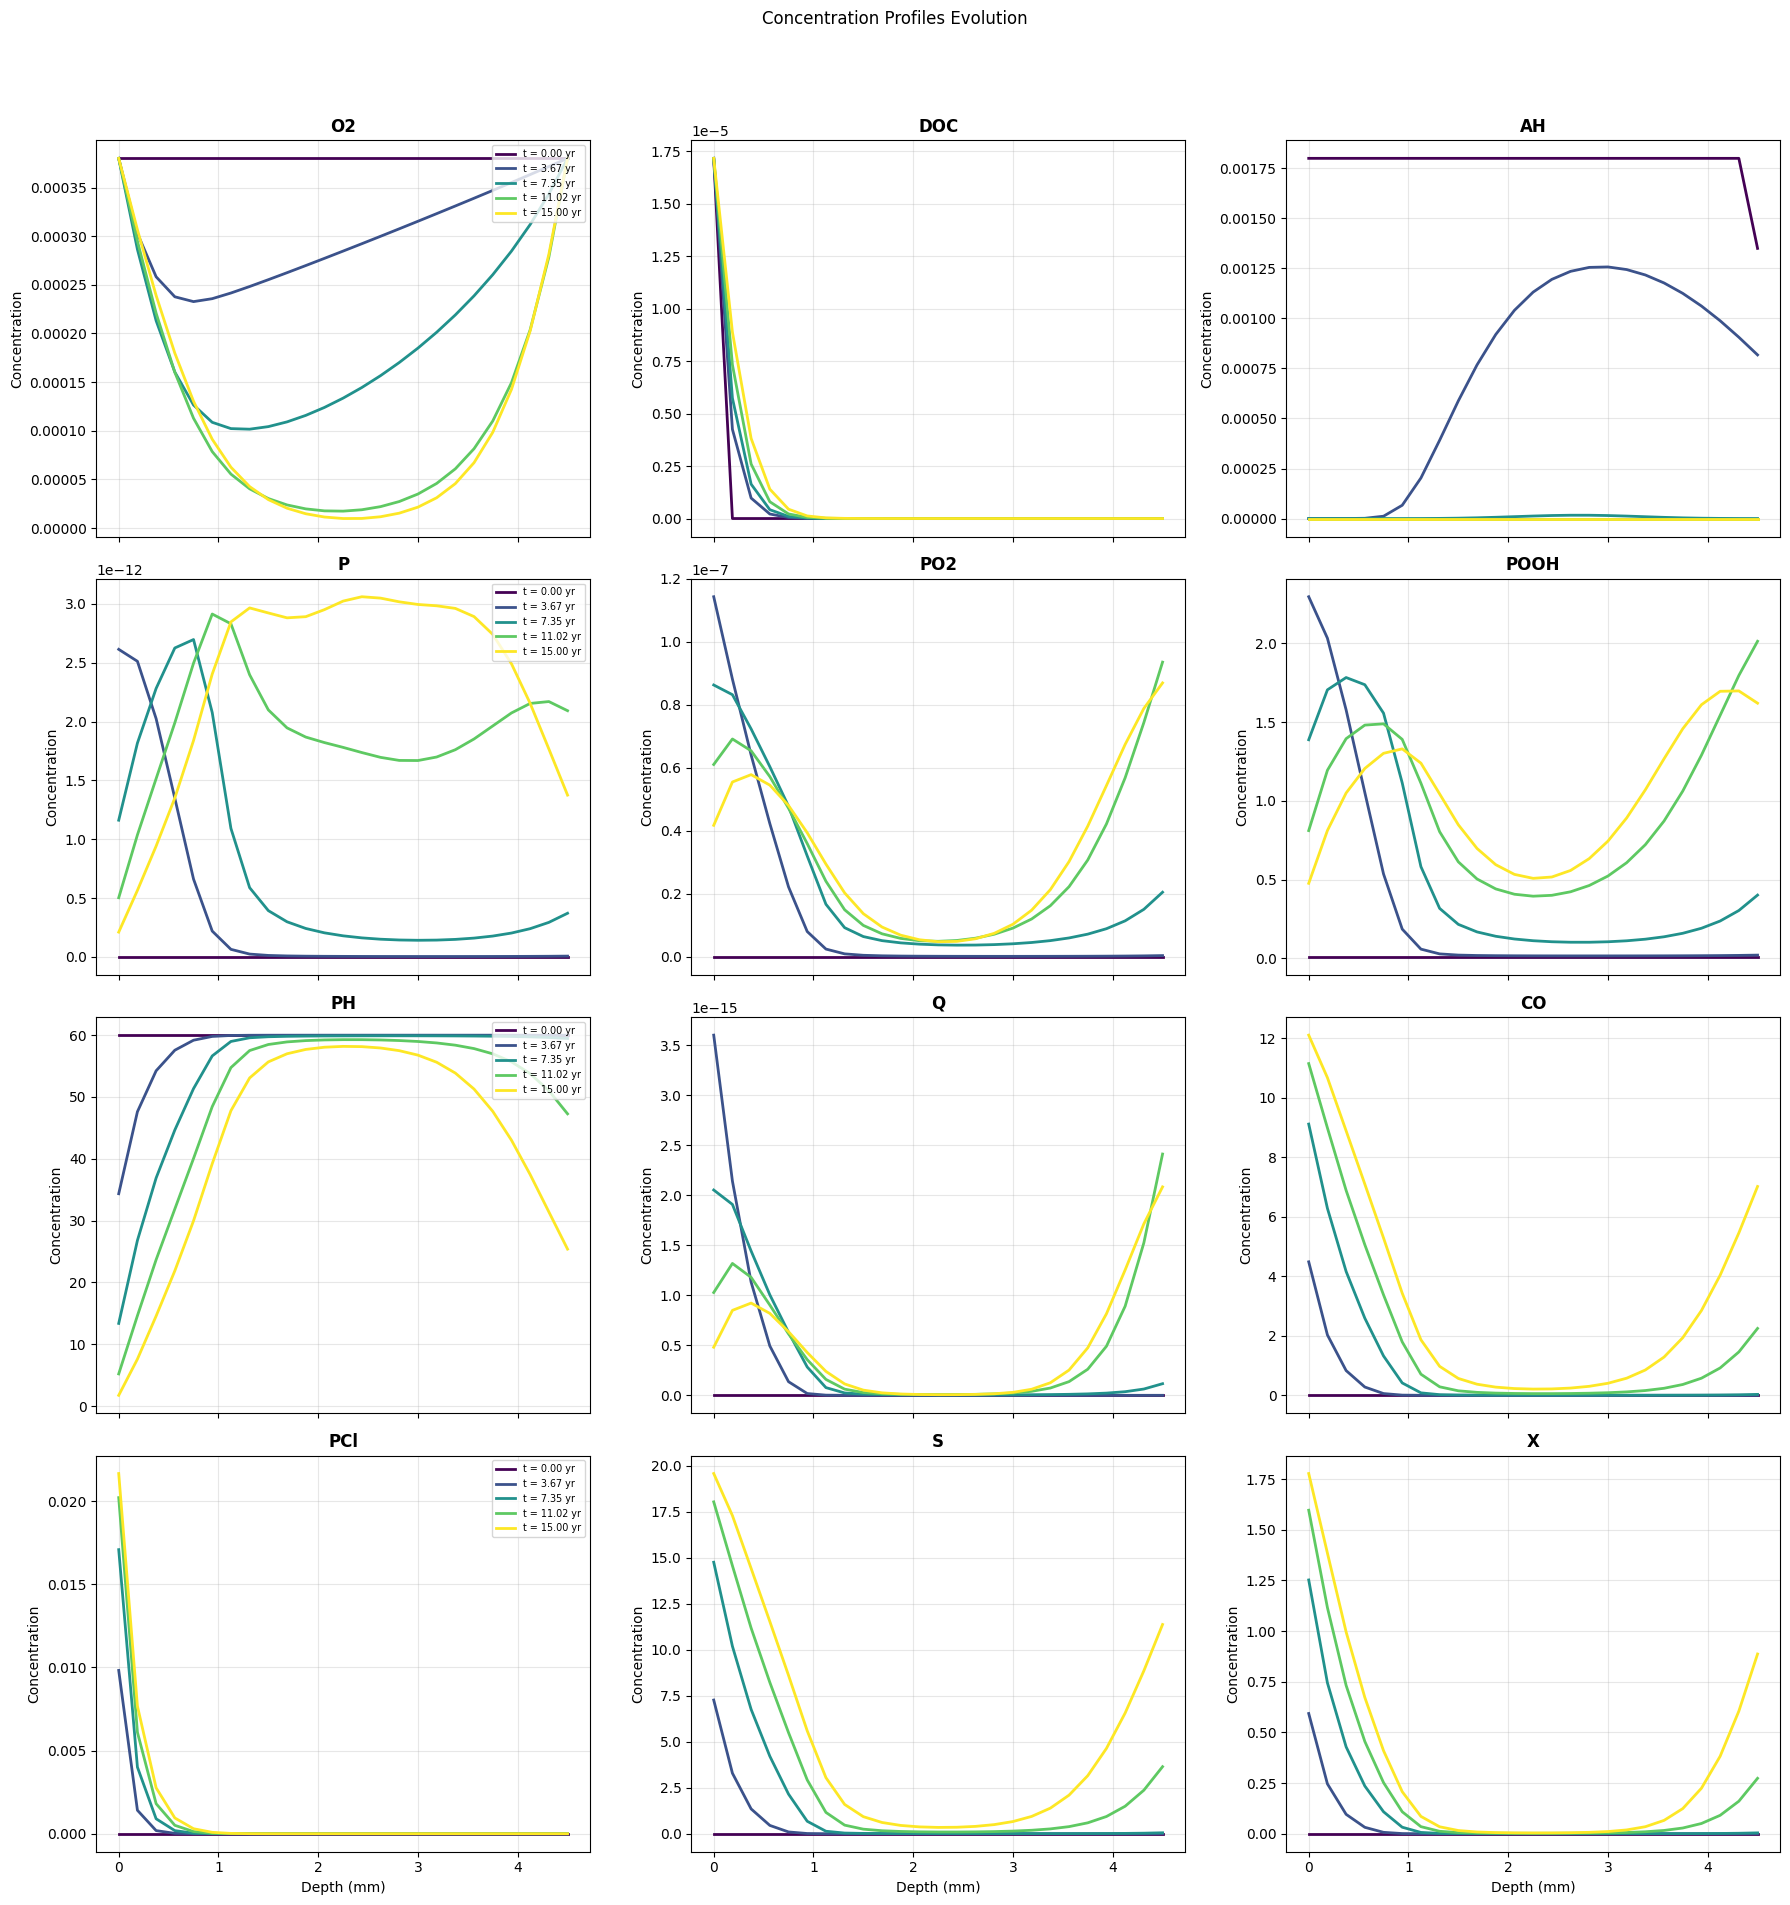


---inary Profile Plotting Finished ---


In [ ]:
if __name__ == "__main__":
    pipe_thickness_m = 4.5e-3 
    num_grid_points = 25
    model = ColinPEDegradationModel2(L=pipe_thickness_m, nz=num_grid_points)

        # Use default AH0_conc and ti0_oit from the model for this general showcase
        # Or set them if you have specific values for a generic PE in mind
        # model.ti0_oit = 165.0 # If needed for other calculations, not directly for these conc plots

        # --- Simulation Conditions forinary Plot ---
    T_celsius = 40
    DOC_ppm = 1 # A moderate DOC concentration
    t_end_years = 15 # Simulate for about 1.2 months (0.1 years)
                            # Adjust if you want to see longer-term evolution
    n_timepoints = 50 # Number of time points for the output solution

    print(f"\n--- Runninginary Simulation for Profile Plots ---")
    print(f"T={T_celsius}°C, DOC={DOC_ppm} ppm, Time={t_end_years:.2f} years, L={pipe_thickness_m*1000:.1f}mm")
        
    trial = [{'method': 'Radau', 'rtol': 1e-6, 'atol': 1e-9},
            {'method': 'BDF', 'rtol': 1e-6, 'atol': 1e-9},
            {'method': 'Radau', 'rtol': 1e-5, 'atol': 1e-8},
            {'method': 'BDF', 'rtol': 1e-5, 'atol': 1e-8}]

        # For this general run, use AH0_mult=1.0 (i.e., model's default AH0_conc)
        # unless you want to simulate Sample A specifically again.
    for params in trial:
        print(f"\nRunninginary simulation with method={params['method']}, rtol={params['rtol']:.1e}, atol={params['atol']:.1e}")
        model.simulation_mode = 'pipe'   
        solution = model.simulate(
            T_celsius=T_celsius,
            DOC_ppm=DOC_ppm,
            t_end_years=t_end_years,
            n_timepoints=n_timepoints,
            AH0_mult=1.0,
            rtol=params['rtol'],
            atol=params['atol'],
            method=params['method']
        )
        if solution.success:
            break
            
    if solution.success:
        print(f"simulation successful.")
        species_for_profile_plot = ['O2', 'DOC', 'AH', 'P', 'PO2', 'POOH', 'PH', 'Q', 'CO', 'PCl', 'S', 'X']
            # Select specific time points for plotting (e.g., initial, quarter, half, three-quarters, final)
            # Ensure selected_time_indices are valid for n_timepoints
        num_plot_profiles = 5
        plot_indices = np.linspace(0, n_timepoints - 1, num_plot_profiles, dtype=int)    
        fig_profiles, axes_profiles = pf.plot_profiles_evolution(
            model,
            sol=solution,
            species_to_plot=species_for_profile_plot,
            selected_time_indices=plot_indices
        )
        
        #save the profile plot
        fig_profiles.savefig(f"profils_concentration_preliminaires.png", dpi=300)
        # Show the profile plots if desired
        if fig_profiles:
            plt.show()
    else:
        print(f"simulation FAILED: {solution.message}")

    print("\n---inary Profile Plotting Finished ---")

### ***Validation face à la littérature***

        Réf. Figure 3, Colin et al. 2009 (Paper [2] (Part II))
        Entrées : pipe_thickness_m, num_grid_points, model_fig3.ti0_oit

--- Step 1.1: Replicating Figure 3 from Paper [2] (Part II) - OIT Profiles ---
Model initialized in 'pipe' mode with L=4.50e-03m, nz=25.

Simulating for Figure 3 condition: (a) 99d, 0ppm DOC
  Using method: Radau, rtol: 0.0001, atol: 1e-07 (Default)
Running simulation: T=40°C, DOC=0.0 ppm, Time=0.271 years, Mode='pipe'
  Solver: Radau, rtol=1.0e-04, atol=1.0e-07
Simulation duration: 7.60 seconds
Simulation successful.
Simulation successful for (a) 99d, 0ppm DOC.

Simulating for Figure 3 condition: (b) 2d, 5ppm DOC
  Using method: Radau, rtol: 0.0001, atol: 1e-07 (Default)
Running simulation: T=40°C, DOC=5.0 ppm, Time=0.005 years, Mode='pipe'
  Solver: Radau, rtol=1.0e-04, atol=1.0e-07
Simulation duration: 24.47 seconds
Simulation successful.
Simulation successful for (b) 2d, 5ppm DOC.

Simulating for Figure 3 condition: (c) 10d, 31.8ppm DOC
  Using method: Radau, rtol: 0.0001, atol: 1e-07 (Default)
Running simulation: T=40°C, DOC=31.8 ppm, Time=0.027 years, Mode='pipe'
  Solver: Radau,

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Simulated OIT Profiles (Compare Paper [2] Fig 3 @ 40°C)'}, xlabel='z (mm)', ylabel='tᵢ (min)'>)

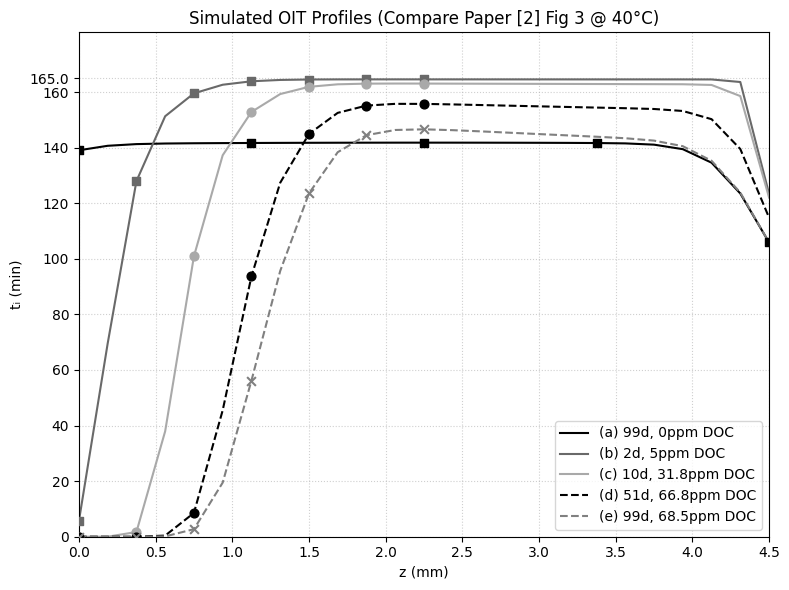

In [ ]:
if __name__ == "__main__":
    print("--- Step 1.1: Replicating Figure 3 from Paper [2] (Part II) - OIT Profiles ---")

    # --- model_fig3 Setup ---
    pipe_thickness_m = 4.5e-3
    num_grid_points = 25
    
    model_fig3 = ColinPEDegradationModel2(L=pipe_thickness_m, nz=num_grid_points, simulation_mode='pipe')
    
    ah_conc_sample_a = (0.001 * model_fig3.dens0 / 1178 * model_fig3.n_AH) 
    ah0_multiplier_for_sample_a = ah_conc_sample_a / model_fig3.AH0_conc 
    model_fig3.ti0_oit = 165.0

    trial = [
        {'method':'Radau', 'rtol': 1e-4, 'atol': 1e-7, 'desc': 'Default'},
        {'method':'BDF', 'rtol': 1e-4, 'atol': 1e-7, 'desc': 'Default'},
        {'method':'Radau', 'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Relaxed 1'},
        {'method':'BDF', 'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Relaxed 1'},
        {'method':'Radau', 'rtol': 1e-2, 'atol': 1e-5, 'desc': 'Relaxed 2'},
        {'method':'BDF', 'rtol': 1e-2, 'atol': 1e-5, 'desc': 'Relaxed 2'},
        {'method':'Radau', 'rtol': 1e-1, 'atol': 1e-4, 'desc': 'Relaxed 3'},
        {'method':'BDF', 'rtol': 1e-1, 'atol': 1e-4, 'desc': 'Relaxed 3'},
    ]
    
    simulation_parameters_fig3 = [
        {'label': '(a) 99d, 0ppm DOC',    'DOC_ppm': 0.0,  't_end_days': 99},
        {'label': '(b) 2d, 5ppm DOC',     'DOC_ppm': 5.0,  't_end_days': 2},
        {'label': '(c) 10d, 31.8ppm DOC', 'DOC_ppm': 31.8, 't_end_days': 10},
        {'label': '(d) 51d, 66.8ppm DOC', 'DOC_ppm': 66.8, 't_end_days': 51},
        {'label': '(e) 99d, 68.5ppm DOC', 'DOC_ppm': 68.5, 't_end_days': 99},
    ]

    results_fig3_data = {} 

    for params in simulation_parameters_fig3:
        print(f"\nSimulating for Figure 3 condition: {params['label']}")
        t_end_years_fig3 = params['t_end_days'] / 365.25
        
        for trial_params in trial:
            rtol_val = trial_params['rtol']
            atol_val = trial_params['atol']
            method_val = trial_params['method']
            print(f"  Using method: {method_val}, rtol: {rtol_val}, atol: {atol_val} ({trial_params['desc']})")

            solution_fig3 = model_fig3.simulate(
                T_celsius=40,
                DOC_ppm=params['DOC_ppm'],
                t_end_years=t_end_years_fig3,
                n_timepoints=20,
                AH0_mult=ah0_multiplier_for_sample_a,
                rtol=rtol_val,
                atol=atol_val,
                method=method_val
            )
            
            if solution_fig3.success:
                print(f"Simulation successful for {params['label']}.")
                C_all_times = solution_fig3.y.reshape((model_fig3.n_species, model_fig3.nz, len(solution_fig3.t)))
                AH_profile_final = C_all_times[model_fig3.idx['AH'], :, -1]
                AH0_actual_conc_used = solution_fig3.sim_params['AH0_conc_used']
                oit_profile_final = model_fig3.calculate_oit(AH_profile_final, AH0_actual_conc_used)

                results_fig3_data[params['label']] = {
                'z_coords_mm': model_fig3.z * 1000,
                'oit_profile_final': oit_profile_final,
                }
                break
            
            if len(oit_profile_final) > 0:
                 print(f"OIT profile calculated. Min OIT: {np.min(oit_profile_final):.2f}, Max OIT: {np.max(oit_profile_final):.2f}")
            else:
                 print("OIT profile is empty.")
        else:
            print(f"Simulation FAILED for {params['label']}: {solution_fig3.message}")
            results_fig3_data[params['label']] = None

    print("\n--- Step 1.1 Execution Finished ---")

model_fig3.plot_figure_3_oit_profiles(results_fig3_data)

        Réf. Figure 4, Colin et al. 2009 (Paper [2] (Part II)) - OIT and Carbonyl Profiles
        Entrées : pipe_thickness_m, num_grid_points, model_fig4.ti0_oit, doc_ppm_fig4, t_end_days_fig4
        Analyse de sensibilité sur betaL 

Model initialized in 'pipe' mode with L=4.50e-03m, nz=25.
Simulating for Figure 4: 99d, 66.5ppm DOC, 40°C

Simulating for Figure 4 condition: 99d, 0ppm DOC, 40ºC
  Using method: Radau, rtol: 0.0001, atol: 1e-07 (Default)
Running simulation: T=40°C, DOC=66.5 ppm, Time=0.271 years, Mode='pipe'
  Solver: Radau, rtol=1.0e-04, atol=1.0e-07
Simulation duration: 36.30 seconds
Simulation successful.
Simulation successful for Figure 4 conditions with method Radau.
OIT Profile (Fig 4): Min=0.00, Max=146.52
CO Profile (Fig 4): Min=1.33e-05, Max=1.38e+00
Method: Radau, rtol: 0.0001, atol: 1e-07


(<Figure size 800x600 with 2 Axes>,
 <Axes: xlabel='z (mm)', ylabel='[CO] (mol/L)'>)

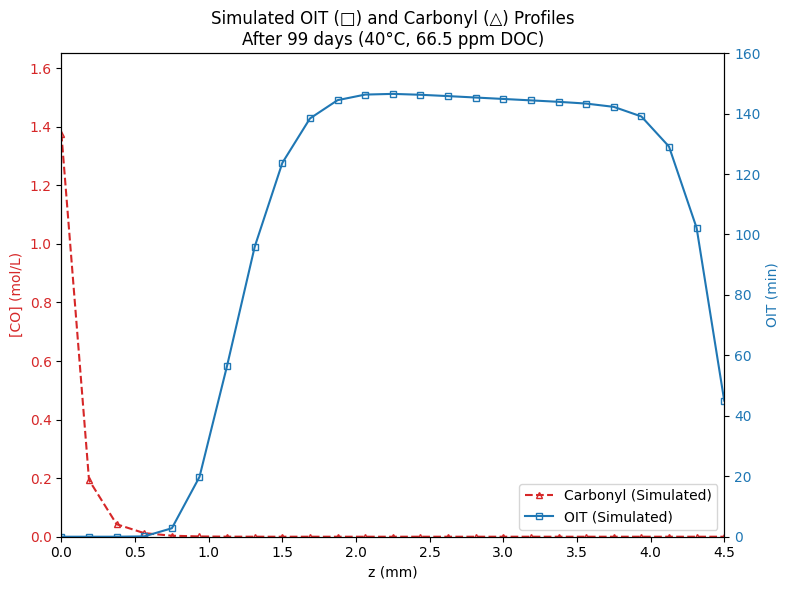

In [ ]:
if __name__ == "__main__":
    pipe_thickness_m = 4.5e-3
    num_grid_points = 25
    
    model_fig4 = ColinPEDegradationModel2(L=pipe_thickness_m, nz=num_grid_points)
    
    ah_conc_sample_a = (0.001 * model_fig4.dens0 / 1178 * model_fig4.n_AH) 
    ah0_multiplier_for_sample_a = ah_conc_sample_a / model_fig4.AH0_conc 
    model_fig4.ti0_oit = 165.0
    t_end_days_fig4 = 99
    doc_ppm_fig4 = 66.5
    #model_fig4.beta_coeffs['beta0']=(0,1.9e-9*1e20)
    model_fig4.beta_coeffs['betaL']=(0,1.0e-10*1e3)
    
    print(f"Simulating for Figure 4: {t_end_days_fig4}d, {doc_ppm_fig4}ppm DOC, 40°C")

    sim_parameters_fig4 = [
        {'label': '99d, 0ppm DOC, 40ºC',    'DOC_ppm': 66.5,  't_end_days': 99},
    ]
    
    trial = [
        {'method':'Radau', 'rtol': 1e-4, 'atol': 1e-7, 'desc': 'Default'},
        {'method':'BDF', 'rtol': 1e-4, 'atol': 1e-7, 'desc': 'Default'},
        {'method':'Radau', 'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Relaxed 1'},
        {'method':'BDF', 'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Relaxed 1'},
        {'method':'Radau', 'rtol': 1e-2, 'atol': 1e-5, 'desc': 'Relaxed 2'},
        {'method':'BDF', 'rtol': 1e-2, 'atol': 1e-5, 'desc': 'Relaxed 2'},
        {'method':'Radau', 'rtol': 1e-1, 'atol': 1e-4, 'desc': 'Relaxed 3'},
        {'method':'BDF', 'rtol': 1e-1, 'atol': 1e-4, 'desc': 'Relaxed 3'},
    ]

    results_fig4_data = {}

    for params in sim_parameters_fig4:
        print(f"\nSimulating for Figure 4 condition: {params['label']}")
        t_end_years_fig4 = params['t_end_days'] / 365.25

        for trial_params in trial:
            rtol_val = trial_params['rtol']
            atol_val = trial_params['atol']
            method_val = trial_params['method']
            print(f"  Using method: {method_val}, rtol: {rtol_val}, atol: {atol_val} ({trial_params['desc']})")

            solution_fig4 = model_fig4.simulate(
                T_celsius=40,
                DOC_ppm=params['DOC_ppm'],
                t_end_years=t_end_years_fig4,
                n_timepoints=20,
                AH0_mult=ah0_multiplier_for_sample_a,
                rtol=rtol_val,
                atol=atol_val,
                method=method_val
            )
        
            if solution_fig4.success:
                print(f"Simulation successful for Figure 4 conditions with method {trial_params['method']}.")

                C_all_times = solution_fig4.y.reshape((model_fig4.n_species, model_fig4.nz, len(solution_fig4.t)))
                AH_profile_final = C_all_times[model_fig4.idx['AH'], :, -1]
                AH0_actual_conc_used = solution_fig4.sim_params['AH0_conc_used']
                oit_profile_final = model_fig4.calculate_oit(AH_profile_final, AH0_actual_conc_used)
                co_profile_final = C_all_times[model_fig4.idx['CO'], :, -1]

                results_fig4_data[params['label']] = {
                    'z_coords_mm': model_fig4.z * 1000,
                    'oit_profile_final': oit_profile_final,
                    'co_profile_final': co_profile_final,
                    'T_celsius': solution_fig4.sim_params['T_celsius'],
                    'DOC_ppm': solution_fig4.sim_params['DOC_ppm'],
                    'time_days_exposure': t_end_days_fig4
                    }
                
                print(f"OIT Profile (Fig 4): Min={np.min(oit_profile_final):.2f}, Max={np.max(oit_profile_final):.2f}"),
                print(f"CO Profile (Fig 4): Min={np.min(co_profile_final):.2e}, Max={np.max(co_profile_final):.2e}")
                print(f"Method: {trial_params['method']}, rtol: {trial_params['rtol']}, atol: {trial_params['atol']}")
                break
        
            else:
                print(f"Simulation FAILED for Figure 4 conditions: {solution_fig4.message}")

model_fig4.plot_figure_4_oit_co(plot_data=results_fig4_data['99d, 0ppm DOC, 40ºC'],
                           L_pipe_mm=model_fig4.L * 1000,
                           initial_ti0_for_plot_ylim=model_fig4.ti0_oit,
)

### ***Validation face aux resultats des DSC (OIT)***

        Vieillissement en Eau Pure (H₂O): pipe_thickness_m= 0.4mm, ti0=291.07, temp_aging_celsius = 40ºC

Model initialized in 'film' mode with L=4.00e-04m, nz=25.
  Film mode: beta_coeffs['betaL'] parameters set to beta_coeffs['beta0'] (Ea=0, A=1.9e-09)
Utilisation de AH0_multiplier: 1.79

--- Simulation pour Diapositive 3: Vieillissement en Eau Pure (OIT vs. Temps jusqu'à 9 mois) ---

Simulating H2O aging for 0.0 months (année: 0.000)...
  Time t=0, OIT is initial OIT.

Simulating H2O aging for 1.0 months (année: 0.083)...
  Attempting with: method=Radau, rtol=1e-06, atol=1e-09 (Default Radau)
  FILM MODE: Initial C0[DOC, L] set to 0.00e+00
Running simulation: T=40°C, DOC=0 ppm, Time=0.083 years, Mode='film'
  Solver: Radau, rtol=1.0e-06, atol=1.0e-09
Simulation duration: 4.43 seconds
Simulation successful.
  Success with method=Radau, rtol=1e-06, atol=1e-09
    Time: 1.0 mois, OIT Moyen Simulé: 266.70 min

Simulating H2O aging for 2.0 months (année: 0.167)...
  Attempting with: method=Radau, rtol=1e-06, atol=1e-09 (Default Radau)
  FILM MODE: Initial C0[DOC, L] set to 0.00e+00
Running s

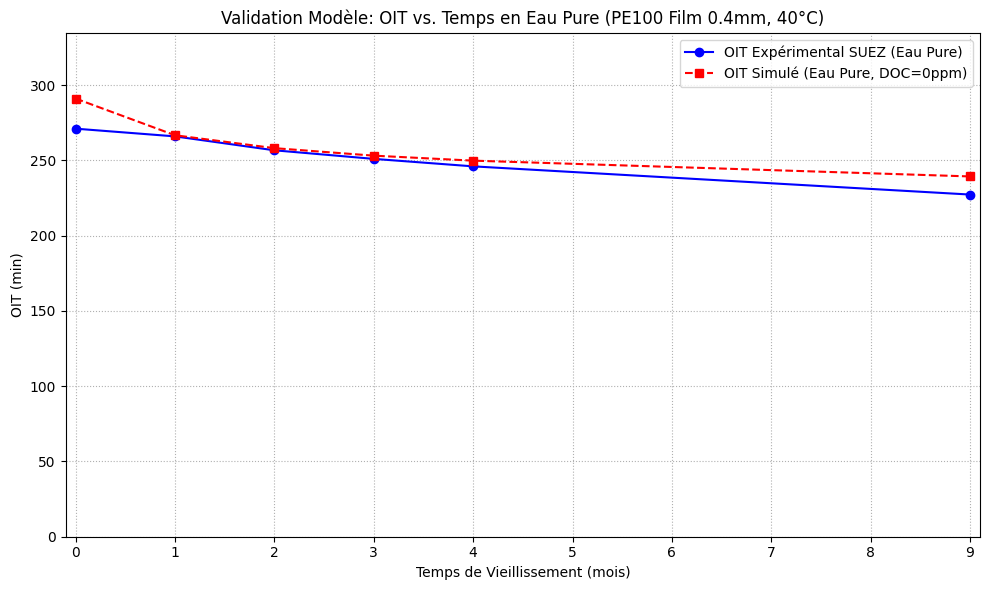


--- Données pour Diapositive 3 (Vieillissement Eau Pure, jusqu'à 9 mois) ---
Mois | OIT Exp (min) | OIT Sim (min)
--------------------------------------
0    | 271.07        | 291.07       
1    | 265.95        | 266.70       
2    | 256.70        | 258.13       
3    | 251.00        | 253.14       
4    | 246.03        | 249.82       
9    | 227.30        | 239.34       

--- Fin du script pour Diapositive 3 ---


<Figure size 640x480 with 0 Axes>

In [ ]:
if __name__ == "__main__":
    # --- Configuration du Modèle et des Paramètres pour les Essais SUEZ PE100 ---
    pipe_thickness_m = 0.4e-3  # ATTENTION: Mettez l'épaisseur RÉELLE de votre film PE100 en mètres !
    num_grid_points = 25       
    
    model_film = ColinPEDegradationModel2(L=pipe_thickness_m, nz=num_grid_points, simulation_mode='film')

    #model_film.beta_coeffs['betaL'] = model_film.beta_coeffs['beta0'] = (0, 1.9e-9)
    model_film.ti0_oit = 291.07
    
    # Mettez à jour AH0_mult si vous avez une meilleure estimation pour VOTRE PE100
    ah_conc_sample_a = (0.001 * (model_film.dens0 * 1000) / 1178 * model_film.n_AH) 
    ah0_multiplier = ah_conc_sample_a / model_film.AH0_conc 
    # ou ah0_multiplier = 1.0 # si vous faites cette hypothèse
    # ou ah0_multiplier = model_film.ti0_oit / 165.0 # autre hypothèse

    print(f"Utilisation de AH0_multiplier: {ah0_multiplier:.2f}")

    temp_aging_celsius = 40 # ATTENTION: Mettez la température de VOS essais SUEZ !

    # === DONNÉES EXPÉRIMENTALES SUEZ (EAU PURE) ===
    # ATTENTION: REMPLACEZ CES VALEURS PAR VOS DONNÉES EXPÉRIMENTALES EXACTES
    experimental_times_months_h2o = np.array([0, 1, 2, 3, 4, 9]) # Ajout de 9 mois
    time_under_azote = 22 
    ti0_experimental_corrigee = 271.07 
    
    experimental_oit_h2o = np.array([
        ti0_experimental_corrigee,                   # t=0
        287.95 - time_under_azote,                   # t=1 mois
        278.7 - time_under_azote,                    # t=2 mois
        273 - time_under_azote,                      # t=3 mois
        268.03 - time_under_azote,                   # t=4 mois
        249.3 - time_under_azote                     # t=9 mois
    ])

    
    """experimental_times_months_h2o = np.array([0, 1, 2, 3, 4, 6, 9]) # Étendu à 9 mois
    experimental_oit_h2o = np.array([
        275.0,  # t=0 mois (VOTRE VALEUR)
        270.0,  # t=1 mois (VOTRE VALEUR)
        265.0,  # t=2 mois (VOTRE VALEUR)
        260.0,  # t=3 mois (VOTRE VALEUR)
        255.0,  # t=4 mois (VOTRE VALEUR)
        np.nan, # t=6 mois (mettez np.nan si pas encore dispo, sinon la valeur)
        np.nan  # t=9 mois (mettez np.nan si pas encore dispo, sinon la valeur)
    ])"""

    if len(experimental_times_months_h2o) != len(experimental_oit_h2o):
        raise ValueError("Les tableaux de temps et d'OIT expérimentaux doivent avoir la même longueur!")

    # --- Simulation pour Vieillissement en Eau Pure (jusqu'à 9 mois) ---
    print("\n--- Simulation pour Diapositive 3: Vieillissement en Eau Pure (OIT vs. Temps jusqu'à 9 mois) ---")
    
    # Nous simulons pour les mêmes points de temps que les expériences pour une comparaison directe
    simulated_times_years_h2o = experimental_times_months_h2o / 12.0
    simulated_oit_avg_h2o = []

    trial_methods = [
        {'method': 'Radau', 'rtol': 1e-6, 'atol': 1e-9, 'desc': 'Default Radau'},
        {'method': 'BDF',   'rtol': 1e-6, 'atol': 1e-9, 'desc': 'Default BDF'}
    ]
    
    for t_idx, t_years in enumerate(simulated_times_years_h2o):
        current_month = experimental_times_months_h2o[t_idx]
        print(f"\nSimulating H2O aging for {current_month:.1f} months (année: {t_years:.3f})...")
        simulation_succeeded_for_this_time_point = False
        
        if np.isclose(t_years, 0.0):
            print("  Time t=0, OIT is initial OIT.")
            simulated_oit_avg_h2o.append(model_film.ti0_oit)
            simulation_succeeded_for_this_time_point = True
            continue

        for trial_params in trial_methods:
            print(f"  Attempting with: method={trial_params['method']}, rtol={trial_params['rtol']}, atol={trial_params['atol']} ({trial_params['desc']})")
            
            solution_h2o = model_film.simulate(
                T_celsius=temp_aging_celsius,
                DOC_ppm=0,
                t_end_years=t_years,
                n_timepoints=10, 
                AH0_mult=ah0_multiplier,
                method=trial_params['method'], 
                rtol=trial_params['rtol'],    
                atol=trial_params['atol']
            )

            if solution_h2o.success:
                if solution_h2o.y.size == 0:
                    print(f"    Simulation SUCCÈS mais sol.y VIDE avec {trial_params['desc']}. Essai suivant.")
                    if trial_params == trial_methods[-1]: # Si c'est le dernier essai
                        print(f"    Tous les essais ont retourné sol.y vide pour {current_month:.1f} mois.")
                    continue # Passer à l'essai suivant de tolérance/méthode

                print(f"  Success with method={trial_params['method']}, rtol={trial_params['rtol']}, atol={trial_params['atol']}")
                y_data = np.array(solution_h2o.y)

                if y_data.ndim == 1:
                    final_time_state_vector_1D = y_data
                elif y_data.ndim == 2:
                    final_time_state_vector_1D = y_data[:, -1]
                else:
                    print(f"    ERREUR: Forme inattendue pour solution_h2o.y: {y_data.shape}. Essai suivant.")
                    continue
                
                if final_time_state_vector_1D.size != (model_film.n_species * model_film.nz):
                    print(f"    ERREUR: Taille inattendue pour final_time_state_vector_1D: {final_time_state_vector_1D.size}. Attendu: {model_film.n_species * model_film.nz}. Essai suivant.")
                    continue

                C_final = final_time_state_vector_1D.reshape((model_film.n_species, model_film.nz))
                AH_profile_final = C_final[model_film.idx['AH'], :]
                AH0_actual_conc_used = solution_h2o.sim_params['AH0_conc_used']
                
                oit_profile_final = model_film.calculate_oit(AH_profile_final, AH0_actual_conc_used)
                oit_avg = np.mean(oit_profile_final) if len(oit_profile_final) > 0 else np.nan
                simulated_oit_avg_h2o.append(oit_avg)
                print(f"    Time: {current_month:.1f} mois, OIT Moyen Simulé: {oit_avg:.2f} min")
                simulation_succeeded_for_this_time_point = True
                break 
            else:
                print(f"    Simulation ÉCHEC pour {current_month:.1f} mois avec {trial_params['desc']}: {solution_h2o.message}")
        
        if not simulation_succeeded_for_this_time_point:
            print(f"  Tous les essais ont ÉCHOUÉ pour {current_month:.1f} mois. Ajout de NaN.")
            simulated_oit_avg_h2o.append(np.nan)

    simulated_oit_avg_h2o = np.array(simulated_oit_avg_h2o)

    # --- Génération du Graphique pour Diapositive 3 (étendu à 9 mois) ---
    plt.figure(figsize=(10, 6))
    
    # Tracer les données expérimentales disponibles (filtrer les NaN)
    valid_exp_indices = ~np.isnan(experimental_oit_h2o)
    if np.any(valid_exp_indices):
        plt.plot(experimental_times_months_h2o[valid_exp_indices], experimental_oit_h2o[valid_exp_indices], 
                 marker='o', linestyle='-', color='blue', label='OIT Expérimental SUEZ (Eau Pure)')
    
    # Tracer les données simulées valides
    valid_sim_indices = ~np.isnan(simulated_oit_avg_h2o)
    if np.any(valid_sim_indices):
        plt.plot(experimental_times_months_h2o[valid_sim_indices], simulated_oit_avg_h2o[valid_sim_indices], 
                 marker='s', linestyle='--', color='red', label=f'OIT Simulé (Eau Pure, DOC=0ppm)')

    plt.xlabel("Temps de Vieillissement (mois)")
    plt.ylabel("OIT (min)")
    plt.title(f"Validation Modèle: OIT vs. Temps en Eau Pure (PE100 Film {pipe_thickness_m*1000:.1f}mm, {temp_aging_celsius}°C)")
    plt.legend()
    plt.grid(True, linestyle=':')
    
    # Ajuster les limites de l'axe Y dynamiquement
    all_valid_oit_values = []
    if np.any(valid_exp_indices): all_valid_oit_values.extend(experimental_oit_h2o[valid_exp_indices])
    if np.any(valid_sim_indices): all_valid_oit_values.extend(simulated_oit_avg_h2o[valid_sim_indices])
    if not all_valid_oit_values: all_valid_oit_values.append(model_film.ti0_oit) # Au cas où tout est NaN
    
    plt.ylim(bottom=0, top=max(all_valid_oit_values) * 1.15 if all_valid_oit_values else model_film.ti0_oit * 1.15)
    plt.xlim(left=-0.1, right=9.1) # Pour bien voir les points à 0 et 9 mois
    plt.xticks(np.arange(0, 10, 1)) # Ticks pour chaque mois
    
    plt.tight_layout()
    plt.show()

    # --- Affichage des Données pour la Diapositive ---
    print("\n--- Données pour Diapositive 3 (Vieillissement Eau Pure, jusqu'à 9 mois) ---")
    print("Mois | OIT Exp (min) | OIT Sim (min)")
    print("--------------------------------------")
    for i, t_m in enumerate(experimental_times_months_h2o):
        exp_val_str = f"{experimental_oit_h2o[i]:.2f}" if not np.isnan(experimental_oit_h2o[i]) else "N/A"
        sim_val_str = f"{simulated_oit_avg_h2o[i]:.2f}" if i < len(simulated_oit_avg_h2o) and not np.isnan(simulated_oit_avg_h2o[i]) else "N/A (ou échec)"
        print(f"{t_m:<4} | {exp_val_str:<13} | {sim_val_str:<13}")

    print("\n--- Fin du script pour Diapositive 3 ---")
    plt.savefig("oit_h2o_exp_suez.png", dpi=300, bbox_inches='tight')

        Vieillissement en Eau de Javel (HOCl): 
        pipe_thickness_m= 0.4mm, ti0=291.07, temp_aging_celsius = 40ºC, effective_doc_ppm_for_hocl = 0.05

Model initialized in 'film' mode with L=4.00e-04m, nz=5.
  Film mode: beta_coeffs['betaL'] parameters set to beta_coeffs['beta0'] (Ea=0, A=1.9e-09)
Utilisation de AH0_multiplier pour HOCl: 1.79
ATTENTION: Utilisation d'une [DOC]eff de 0.05 ppm pour simuler l'HOCl.

--- Simulation pour Diapositive 4: Vieillissement en HOCl (OIT vs. Temps jusqu'à 9 mois) ---

Simulating HOCl aging for 0.0 months (année: 0.000)...
  Time t=0, OIT is initial OIT.

Simulating HOCl aging for 1.0 months (année: 0.083)...
  Attempting with: method=Radau, rtol=1e-06, atol=1e-09 (Default Radau)
  FILM MODE: Initial C0[DOC, L] set to 8.58e-07
Running simulation: T=40.0°C, DOC=0.05 ppm, Time=0.083 years, Mode='film'
  Solver: Radau, rtol=1.0e-06, atol=1.0e-09
Simulation duration: 0.16 seconds
Simulation successful.
  Success with method=Radau, rtol=1e-06, atol=1e-09
    Time: 1.0 mois, OIT Moyen Simulé: 113.64 min

Simulating HOCl aging for 2.0 months (année: 0.167)...
  Attempting with: method=Radau, rtol=1e-06, 

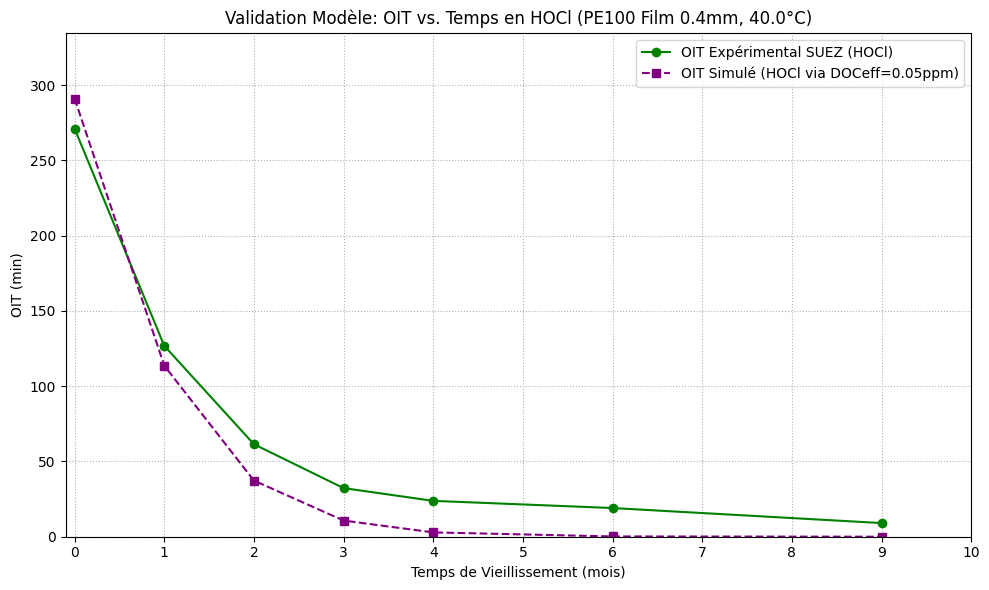


--- Données pour Diapositive 4 (Vieillissement HOCl - OIT) ---

--- Fin du script pour Diapositive 4 (HOCl - OIT) ---


In [ ]:
if __name__ == "__main__":
    # --- Re-use or Re-initialize Model Instance for Film ---
    # If you ran H2O simulations before, model_film is already configured.
    # If not, or if you want a fresh instance for clarity:
    pipe_thickness_m = 0.4e-3  # YOUR PE100 film thickness in meters
    num_grid_points = 5      
    
    # Ensure you are using ColinPEDegradationModel2 (or whatever you named the modified class)
    model_film_hocl = ColinPEDegradationModel2( 
        L=pipe_thickness_m, 
        nz=num_grid_points,
        simulation_mode='film' # CRITICAL for film boundary conditions
    )

    # Set specific parameters for YOUR SUEZ PE100
    model_film_hocl.ti0_oit = 291.07  # Your experimental initial OIT for PE100

    # AH0_multiplier (same logic as for H2O aging)
    ah_conc_target_for_film = (0.001 * (model_film_hocl.dens0 * 1000) / 1178 * model_film_hocl.n_AH) 
    ah0_multiplier = ah_conc_target_for_film / model_film_hocl.AH0_conc
    # Or your chosen/calibrated ah0_multiplier, e.g., ah0_multiplier = 1.0
    print(f"Utilisation de AH0_multiplier pour HOCl: {ah0_multiplier:.2f}")

    temp_aging_celsius = 40.0 # YOUR SUEZ experimental temperature

    # === CHOIX CRUCIAL : "Effective DOC ppm" pour simuler l'HOCl ===
    # This needs to be justified in your presentation.
    # Option 1: Calibrate based on initial OIT drop (as discussed)
    # Option 2: Assume a value and state it as an exploratory step.
    # Let's pick an example value for now. YOU NEED TO DETERMINE/JUSTIFY THIS.
    effective_doc_ppm_for_hocl = 0.05 # EXAMPLE VALUE - ADJUST THIS
    print(f"ATTENTION: Utilisation d'une [DOC]eff de {effective_doc_ppm_for_hocl} ppm pour simuler l'HOCl.")


    # === DONNÉES EXPÉRIMENTALES SUEZ (HOCl) ===
    # Vos données OIT expérimentales exactes pour HOCl
    experimental_times_months_hocl = np.array([0, 1, 2, 3, 4, 6, 9]) 
    time_under_azote = 20 
    experimental_oit_hocl = np.array([291.07-time_under_azote, 146.81-time_under_azote, 81.44-time_under_azote, 52.29-time_under_azote, 43.82-time_under_azote, 39.06-time_under_azote, 29.07-time_under_azote])

    if len(experimental_times_months_hocl) != len(experimental_oit_hocl):
        raise ValueError("Les tableaux de temps et d'OIT HOCl expérimentaux doivent avoir la même longueur!")

    # --- Simulation pour Vieillissement en HOCl (jusqu'à 9 mois) ---
    print("\n--- Simulation pour Diapositive 4: Vieillissement en HOCl (OIT vs. Temps jusqu'à 9 mois) ---")
    
    simulated_times_years_hocl = experimental_times_months_hocl / 12.0
    simulated_oit_avg_hocl = []

    # Solver trials (start with what worked, e.g., BDF with reasonable tolerances)
    trial_methods_hocl = [
        {'method': 'Radau', 'rtol': 1e-6, 'atol': 1e-9, 'desc': 'Default Radau'},
        {'method': 'BDF',   'rtol': 1e-6, 'atol': 1e-9, 'desc': 'Default BDF'},
        {'method': 'Radau', 'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Relaxed 1 Radau'},
        {'method': 'BDF',   'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Relaxed 1 BDF'},

        # Add more aggressive ones if needed, but HOCl might be less stiff than high ClO2
    ]
    
    for t_idx, t_years in enumerate(simulated_times_years_hocl):
        current_month = experimental_times_months_hocl[t_idx]
        print(f"\nSimulating HOCl aging for {current_month:.1f} months (année: {t_years:.3f})...")
        simulation_succeeded_for_this_time_point = False
        
        if np.isclose(t_years, 0.0):
            print("  Time t=0, OIT is initial OIT.")
            simulated_oit_avg_hocl.append(model_film_hocl.ti0_oit)
            simulation_succeeded_for_this_time_point = True
            continue

        for trial_params in trial_methods_hocl:
            print(f"  Attempting with: method={trial_params['method']}, rtol={trial_params['rtol']}, atol={trial_params['atol']} ({trial_params['desc']})")
            
            solution_hocl_run = model_film_hocl.simulate( # Use model_film_hocl instance
                T_celsius=temp_aging_celsius,
                DOC_ppm=effective_doc_ppm_for_hocl, # Utilisation du DOC effectif
                t_end_years=t_years,
                n_timepoints=10, 
                AH0_mult=ah0_multiplier,
                method=trial_params['method'], 
                rtol=trial_params['rtol'],    
                atol=trial_params['atol']
            )

            if solution_hocl_run.success:
                if solution_hocl_run.y.size == 0:
                    print(f"    Simulation SUCCÈS mais sol.y VIDE avec {trial_params['desc']}. Essai suivant.")
                    if trial_params == trial_methods_hocl[-1]:
                         print(f"    Tous les essais ont retourné sol.y vide pour {current_month:.1f} mois.")
                    continue

                print(f"  Success with method={trial_params['method']}, rtol={trial_params['rtol']}, atol={trial_params['atol']}")
                y_data = np.array(solution_hocl_run.y)

                final_time_state_vector_1D = None
                if y_data.ndim == 1:
                    if y_data.shape[0] == (model_film_hocl.n_species * model_film_hocl.nz):
                        final_time_state_vector_1D = y_data
                    else:
                        print(f"    ERREUR: Forme 1D inattendue {y_data.shape}. Essai suivant.")
                        continue
                elif y_data.ndim == 2:
                    if y_data.shape[1] > 0:
                        final_time_state_vector_1D = y_data[:, -1]
                    else:
                        print(f"    ATTENTION: sol.y 2D mais sans colonnes temporelles avec {trial_params['desc']}. Essai suivant.")
                        continue
                else:
                    print(f"    ERREUR: Forme y_data inattendue {y_data.ndim} avec {trial_params['desc']}. Essai suivant.")
                    continue
                
                if final_time_state_vector_1D.size != (model_film_hocl.n_species * model_film_hocl.nz):
                    print(f"    ERREUR: Taille inattendue pour final_time_state_vector_1D: {final_time_state_vector_1D.size}. Attendu: {model_film_hocl.n_species * model_film_hocl.nz}. Essai suivant.")
                    continue
                
                C_final = final_time_state_vector_1D.reshape((model_film_hocl.n_species, model_film_hocl.nz))
                AH_profile_final = C_final[model_film_hocl.idx['AH'], :]
                AH0_actual_conc_used = solution_hocl_run.sim_params['AH0_conc_used']
                
                oit_profile_final = model_film_hocl.calculate_oit(AH_profile_final, AH0_actual_conc_used)
                oit_avg = np.mean(oit_profile_final) if len(oit_profile_final) > 0 else np.nan
                simulated_oit_avg_hocl.append(oit_avg)
                print(f"    Time: {current_month:.1f} mois, OIT Moyen Simulé: {oit_avg:.2f} min")
                simulation_succeeded_for_this_time_point = True
                break 
            else:
                print(f"    Simulation ÉCHEC pour {current_month:.1f} mois avec {trial_params['desc']}: {solution_hocl_run.message}")
        
        if not simulation_succeeded_for_this_time_point:
            print(f"  Tous les essais ont ÉCHOUÉ pour {current_month:.1f} mois. Ajout de NaN.")
            simulated_oit_avg_hocl.append(np.nan)

    simulated_oit_avg_hocl = np.array(simulated_oit_avg_hocl)

# (Votre code existant pour la simulation HOCl...)

    # --- Génération du Graphique pour Diapositive 4 (HOCl OIT vs Temps) ---
    if len(experimental_times_months_hocl) > 0:
        # 1. CRÉER LA FIGURE ET LES AXES
        fig_hocl_oit, ax_hocl_oit = plt.subplots(figsize=(10, 6)) # Utiliser des noms de variables distincts
        
        # 2. TRACER TOUTES LES DONNÉES SUR CES AXES
        valid_exp_indices_hocl = ~np.isnan(experimental_oit_hocl)
        if np.any(valid_exp_indices_hocl):
            ax_hocl_oit.plot(experimental_times_months_hocl[valid_exp_indices_hocl], experimental_oit_hocl[valid_exp_indices_hocl], 
                         marker='o', linestyle='-', color='green', label='OIT Expérimental SUEZ (HOCl)')
        
        valid_sim_indices_hocl = ~np.isnan(simulated_oit_avg_hocl)
        if np.any(valid_sim_indices_hocl):
            ax_hocl_oit.plot(experimental_times_months_hocl[valid_sim_indices_hocl], simulated_oit_avg_hocl[valid_sim_indices_hocl], 
                         marker='s', linestyle='--', color='purple', label=f'OIT Simulé (HOCl via DOCeff={effective_doc_ppm_for_hocl}ppm)')

        # 3. METTRE EN FORME LES AXES ET LA FIGURE
        ax_hocl_oit.set_xlabel("Temps de Vieillissement (mois)")
        ax_hocl_oit.set_ylabel("OIT (min)")
        ax_hocl_oit.set_title(f"Validation Modèle: OIT vs. Temps en HOCl (PE100 Film {pipe_thickness_m*1000:.1f}mm, {temp_aging_celsius}°C)")
        ax_hocl_oit.legend()
        ax_hocl_oit.grid(True, linestyle=':')
        
        all_valid_oit_hocl = []
        if np.any(valid_exp_indices_hocl): all_valid_oit_hocl.extend(experimental_oit_hocl[valid_exp_indices_hocl])
        if np.any(valid_sim_indices_hocl): all_valid_oit_hocl.extend(simulated_oit_avg_hocl[valid_sim_indices_hocl])
        if not all_valid_oit_hocl: all_valid_oit_hocl.append(model_film_hocl.ti0_oit if hasattr(model_film_hocl, 'ti0_oit') else 300) # Added hasattr check
            
        max_y_val_hocl = max(all_valid_oit_hocl) if all_valid_oit_hocl else (model_film_hocl.ti0_oit if hasattr(model_film_hocl, 'ti0_oit') else 300)
        ax_hocl_oit.set_ylim(bottom=0, top=max_y_val_hocl * 1.15)
        
        max_x_val_hocl = max(experimental_times_months_hocl) if experimental_times_months_hocl.size > 0 else 9
        ax_hocl_oit.set_xlim(left=-0.1, right=max_x_val_hocl * 1.05 if max_x_val_hocl > 0 else 9.1)
        ax_hocl_oit.set_xticks(np.arange(0, int(max_x_val_hocl) + 2, 1) if max_x_val_hocl > 0 else np.arange(0,10,1)) # Ensure xticks up to max_x_val + 1
        
        fig_hocl_oit.tight_layout() 

        # 4. SAUVEGARDER LA FIGURE
        nom_fichier_figure_hocl = "OIT_vs_Temps_HOCl_PE100_SUEZ.png"
        fig_hocl_oit.savefig(nom_fichier_figure_hocl, dpi=300, bbox_inches='tight') 
        print(f"\nGraphique HOCl sauvegardé sous : {nom_fichier_figure_hocl}")
        
        # 5. AFFICHER LA FIGURE (OPTIONNEL APRÈS SAUVEGARDE, MAIS UTILE POUR VÉRIFICATION)
        plt.show() 

        # --- Affichage des Données pour la Diapositive ---
        print("\n--- Données pour Diapositive 4 (Vieillissement HOCl - OIT) ---")
        # ... (votre code d'affichage tabulaire reste le même) ...

    else:
        print("Pas de points de temps expérimentaux HOCl définis pour tracer ou sauvegarder.")

    print("\n--- Fin du script pour Diapositive 4 (HOCl - OIT) ---")

        Vieillissement Eau de Javel (HOCl) + [CO](t)

Model initialized in 'film' mode with L=4.00e-04m, nz=25.
  Film mode: beta_coeffs['betaL'] parameters set to beta_coeffs['beta0'] (Ea=0, A=1.9e-09)
Utilisation de AH0_multiplier pour HOCl: 1.79
ATTENTION: Utilisation d'une [DOC]eff de 0.05 ppm pour simuler l'HOCl.

--- Simulation HOCl (9 mois) pour graphique OIT et Carbonyles vs. Temps ---

Simulation HOCl pour 9.0 mois (année: 0.750)...
  Tentative avec: method=BDF, rtol=0.0001, atol=1e-07 (BDF Défaut)
  FILM MODE: Initial C0[DOC, L] set to 8.58e-07
Running simulation: T=40.0°C, DOC=0.05 ppm, Time=0.750 years, Mode='film'
  Solver: BDF, rtol=1.0e-04, atol=1.0e-07
Simulation duration: 1.15 seconds
Simulation successful.
  SUCCÈS avec method=BDF, rtol=0.0001, atol=1e-07
Simulation HOCl 9 mois réussie, préparation du graphique combiné...
Module 'plot_functions' rechargé pour le tracé.

Graphique Combiné HOCl sauvegardé sous : OIT_CO_vs_Temps_HOCl_SUEZ.png


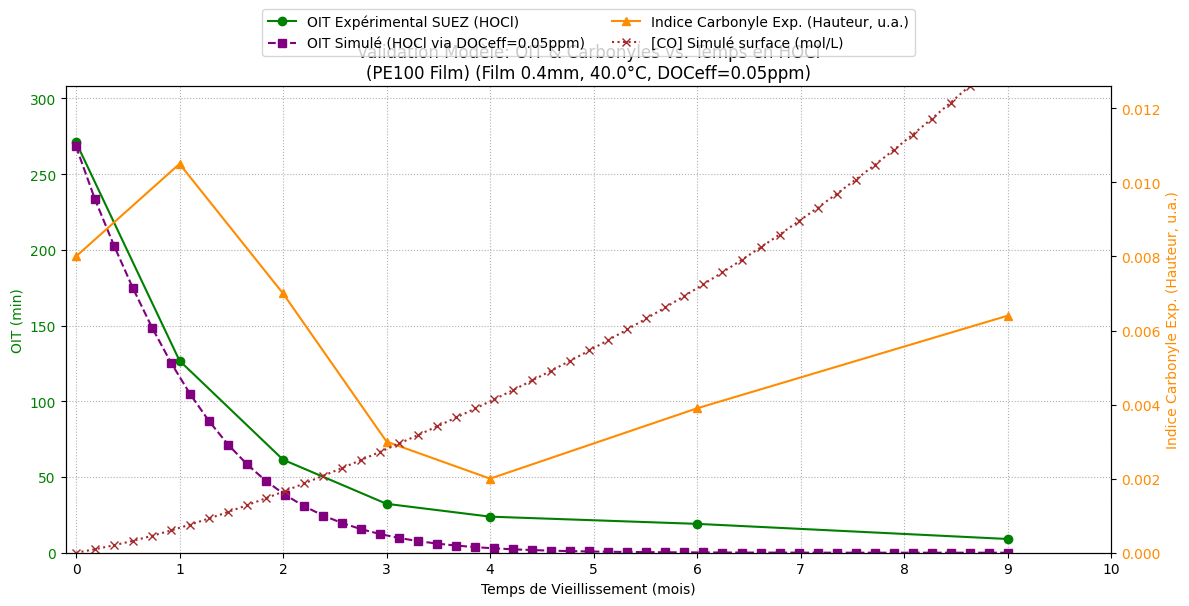


--- Fin du script pour graphique combiné HOCl ---


In [ ]:

importlib.reload(pf) # Recharger le module pour s'assurer que les modifications sont prises en compte

if __name__ == "__main__":
    # --- Configuration du Modèle et des Paramètres pour les Essais SUEZ PE100 ---
    pipe_thickness_m = 0.4e-3 
    num_grid_points = 25 # Gardons 25, car cela semble avoir fonctionné pour vos simulations précédentes
    
    # Initialisation du modèle pour les essais H2O
    model_film_H2O = ColinPEDegradationModel2( 
        L=pipe_thickness_m, 
        nz=num_grid_points,
        simulation_mode='film' 
    )

    # Paramètres spécifiques à VOTRE PE100 SUEZ
    model_film_H2O.ti0_oit = 291.07 - 20.0 # OIT initial corrigé

    # Calcul du AH0_multiplier
    # Assurez-vous que model_film_H2O.dens0 (ou .dens0) et model_film_H2O.AH0_conc ont les valeurs de base attendues
    ah_conc_target_for_film = (0.001 * (model_film_H2O.dens0 * 1000) / 1178 * model_film_H2O.n_AH) # J'utilise .dens0 comme dans votre classe
    ah0_multiplier = ah_conc_target_for_film / model_film_H2O.AH0_conc
    print(f"Utilisation de AH0_multiplier pour H2O: {ah0_multiplier:.2f}")

    temp_aging_celsius = 40.0 # Température des essais SUEZ

    # "Effective DOC ppm" pour simuler l'H2O
    effective_doc_ppm_for_H2O = 0.05 # Votre valeur d'exemple
    print(f"ATTENTION: Utilisation d'une [DOC]eff de {effective_doc_ppm_for_H2O} ppm pour simuler l'H2O.")

    # === DONNÉES EXPÉRIMENTALES SUEZ (H2O) ===
    experimental_times_months_H2O = np.array([0, 1, 2, 3, 4, 9]) 
    time_under_azote = 20 
    experimental_oit_H2O = np.array([
        291.07 - time_under_azote, 287.95 - time_under_azote, 278.7 - time_under_azote, 
        273 - time_under_azote, 268.03 - time_under_azote, 249.3 - time_under_azote
    ])
    
    experimental_carbonyl_index_H2O = np.array([ # Hauteudens0Cl de Recap_PE100
        0.0080, 0.0047, 0.0012, 0.0033, 0.0020, 0.0039, 0.0064
    ])

    if len(experimental_times_months_H2O) != len(experimental_oit_H2O) or \
       len(experimental_times_months_H2O) != len(experimental_carbonyl_index_H2O):
        raise ValueError("Les tableaux de temps, OIT et Carbonyle H2O expérimentaux doivent avoir la même longueur!")

    # --- Simulation pour Vieillissement en H2O (uniquement pour la durée finale de 9 mois) ---
    # La fonction de tracé utilisera la solution de cette simulation pour tracer l'évolution temporelle.
    print("\n--- Simulation H2O (9 mois) pour graphique OIT et Carbonyles vs. Temps ---")
    
    t_years_9_mois = 9.0 / 12.0
    n_timepoints_for_plot = 50 # Assez de points pour des courbes simulées lisses

    solution_H2O_final_run = None # Pour stocker la solution réussie

    # Liste des combinaisons de solveur/tolérances à essayer
    trial_solver_configs = [
        {'method': 'BDF',   'rtol': 1e-4, 'atol': 1e-7, 'desc': 'BDF Défaut'},
        {'method': 'Radau', 'rtol': 1e-4, 'atol': 1e-7, 'desc': 'Radau Défaut'},
        {'method': 'BDF',   'rtol': 1e-3, 'atol': 1e-6, 'desc': 'BDF Relaxé 1'},
        {'method': 'Radau', 'rtol': 1e-3, 'atol': 1e-6, 'desc': 'Radau Relaxé 1'},
        {'method': 'BDF',   'rtol': 1e-2, 'atol': 1e-5, 'desc': 'BDF Relaxé 2 (Agressif)'},
        {'method': 'Radau', 'rtol': 1e-2, 'atol': 1e-5, 'desc': 'Radau Relaxé 2 (Agressif)'}
    ]
    
    print(f"\nSimulation H2O pour 9.0 mois (année: {t_years_9_mois:.3f})...")
    
    for config in trial_solver_configs:
        print(f"  Tentative avec: method={config['method']}, rtol={config['rtol']}, atol={config['atol']} ({config['desc']})")
        
        solution_H2O_final_run = model_film_H2O.simulate( 
            T_celsius=temp_aging_celsius,
            DOC_ppm=effective_doc_ppm_for_H2O, 
            t_end_years=t_years_9_mois,
            n_timepoints=n_timepoints_for_plot, 
            AH0_mult=ah0_multiplier,
            method=config['method'], 
            rtol=config['rtol'],    
            atol=config['atol']
        )

        if solution_H2O_final_run.success and solution_H2O_final_run.y.size > 0 : # Vérifier aussi la taille de y
            print(f"  SUCCÈS avec method={config['method']}, rtol={config['rtol']}, atol={config['atol']}")
            break # Sortir de la boucle des essais si une simulation réussit
        else:
            msg = solution_H2O_final_run.message if solution_H2O_final_run else "Objet solution non créé"
            print(f"    Simulation ÉCHEC avec {config['desc']}: {msg}")
            if config == trial_solver_configs[-1] and (not solution_H2O_final_run or not solution_H2O_final_run.success):
                 print(f"    Tous les essais de solveur/tolérance ont ÉCHOUÉ pour 9.0 mois.")
            
    # --- Génération du Graphique Combiné OIT et Carbonyles ---
    if solution_H2O_final_run and solution_H2O_final_run.success and solution_H2O_final_run.y.size > 0:
        print(f"Simulation H2O 9 mois réussie, préparation du graphique combiné...")
        
        # Recharger le module au cas où vous auriez modifié plot_functions.py
        try:
            importlib.reload(pf) 
            print("Module 'plot_functions' rechargé pour le tracé.")
        except NameError: # Au cas où importlib n'aurait pas été importé plus tôt
            import importlib
            importlib.reload(pf)
            print("Module 'plot_functions' rechargé (après import importlib).")
        except Exception as e:
            print(f"Erreur lors du rechargement de 'plot_functions': {e}")


        if hasattr(pf, 'plot_suez_H2O_validation'):
            fig_comb, ax1_comb, ax2_comb = pf.plot_suez_H2O_validation( # Appel à la fonction du module
                experimental_times_months=experimental_times_months_H2O,
                experimental_oit_H2O=experimental_oit_H2O,
                experimental_carbonyl_H2O=experimental_carbonyl_index_H2O, 
                solution_H2O_sim=solution_H2O_final_run, 
                # === AJOUT DES ARGUMENTS MANQUANTS ===
                model_n_species=model_film_H2O.n_species,
                model_nz=model_film_H2O.nz,
                model_idx_AH=model_film_H2O.idx['AH'],
                model_idx_CO=model_film_H2O.idx['CO'],
                model_L_meters=model_film_H2O.L,
                model_ti0_oit=model_film_H2O.ti0_oit, # C'est le ti0_oit du PE100 que vous avez défini
                # ======================================
                carbonyl_exp_label="Indice Carbonyle Exp. (Hauteur, u.a.)",
                title_extra=f"(PE100 Film)" 
            )
            if fig_comb:
                nom_fichier_fig_comb = "OIT_CO_vs_Temps_H2O_SUEZ.png"
                fig_comb.savefig(nom_fichier_fig_comb, dpi=300, bbox_inches='tight')
                print(f"\nGraphique Combiné H2O sauvegardé sous : {nom_fichier_fig_comb}")
                plt.show()
    
            else:
                print("Échec de la génération du graphique combiné OIT/CO H2O (la fonction de tracé a retourné None).")
        else:
            print("ERREUR: La fonction 'plot_suez_H2O_validation' n'est pas trouvée dans le module 'pf' après rechargement.")
            
    else:
        msg = solution_H2O_final_run.message if solution_H2O_final_run and hasattr(solution_H2O_final_run, 'message') else "Simulation non réussie ou résultats vides"
        print(f"Simulation H2O pour 9 mois a ÉCHOUÉ ou n'a pas produit de résultats valides : {msg}. Graphique non généré.")
    
    print("\n--- Fin du script pour graphique combiné H2O ---")

### ***Perspective sur l'impact sur les Propriétés Mécaniques***
        corrélation de la dégradation chimique (OIT) à la dégradation mécanique (Allongement à la rupture, εr)

Graphique de corrélation sauvegardé sous : correlation_meca_chimie.png


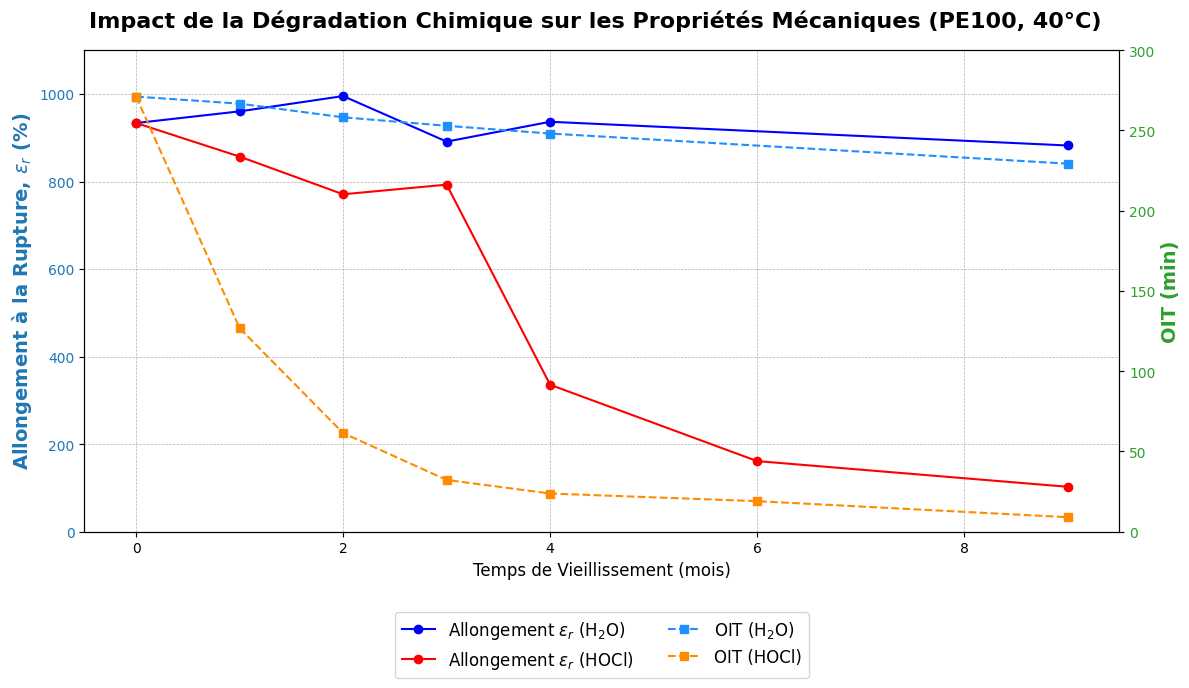

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# --- 1. ENTRÉE DES DONNÉES EXPÉRIMENTALES SUEZ (PE100 / 40°C) ---
# =============================================================================
# Source: Fichier PowerPoint "Suivi étapes discutés...", diapositive 7
# et fichier Recap_PE100.xlsx pour l'OIT

# --- Données pour le vieillissement en EAU PURE (H2O) ---
times_months_h2o = np.array([0, 1, 2, 3, 4, 6, 9])

# OIT corrigé (valeurs que nous avons utilisées précédemment)
oit_h2o = np.array([271.07, 266.67, 258.17, 252.88, 248.06, np.nan, 229.3]) # Pas de mesure à 6 mois

# Allongement à la rupture (%)
elongation_h2o = np.array([933.56, 960.22, 995.14, 891.13, 936.46, np.nan, 882.26]) # Pas de mesure à 6 mois


# --- Données pour le vieillissement en EAU DE JAVEL (HOCl) ---
times_months_hocl = np.array([0, 1, 2, 3, 4, 6, 9])

# OIT corrigé
oit_hocl = np.array([271.07, 126.81, 61.44, 32.29, 23.82, 19.06, 9.07])

# Allongement à la rupture (%)
elongation_hocl = np.array([933.56, 856.88, 770.83, 792.83, 335.79, 161.41, 102.73])


# =============================================================================
# --- 2. CRÉATION DU GRAPHIQUE ---
# =============================================================================

# Initialisation de la figure et du premier axe (pour les propriétés mécaniques)
fig, ax1 = plt.subplots(figsize=(12, 8))

# Titre et labels des axes
fig.suptitle("Impact de la Dégradation Chimique sur les Propriétés Mécaniques (PE100, 40°C)", fontsize=16, weight='bold')
ax1.set_xlabel("Temps de Vieillissement (mois)", fontsize=12)
ax1.set_ylabel("Allongement à la Rupture, $\\epsilon_r$ (%)", color='tab:blue', fontsize=14, weight='bold')

# Tracer les données d'allongement à la rupture
# On filtre les NaN pour ne pas avoir de trou dans le tracé H2O
valid_h2o = ~np.isnan(elongation_h2o)
ax1.plot(times_months_h2o[valid_h2o], elongation_h2o[valid_h2o], marker='o', linestyle='-', color='blue', label='Allongement $\\epsilon_r$ (H$_2$O)')
ax1.plot(times_months_hocl, elongation_hocl, marker='o', linestyle='-', color='red', label='Allongement $\\epsilon_r$ (HOCl)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='major', linestyle='--', linewidth=0.5)

# Création du deuxième axe (pour l'OIT) qui partage le même axe X
ax2 = ax1.twinx()
ax2.set_ylabel("OIT (min)", color='tab:green', fontsize=14, weight='bold')

# Tracer les données d'OIT
ax2.plot(times_months_h2o[valid_h2o], oit_h2o[valid_h2o], marker='s', linestyle='--', color='dodgerblue', label='OIT (H$_2$O)')
ax2.plot(times_months_hocl, oit_hocl, marker='s', linestyle='--', color='darkorange', label='OIT (HOCl)')
ax2.tick_params(axis='y', labelcolor='tab:green')

# =============================================================================
# --- 3. MISE EN FORME ET SAUVEGARDE ---
# =============================================================================

# Créer une légende combinée
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)

# Ajuster les limites des axes pour une meilleure lisibilité
ax1.set_ylim(0, 1100)
ax2.set_ylim(0, 300)
ax1.set_xlim(-0.5, 9.5)

# Ajuster la mise en page pour que la légende soit visible
fig.tight_layout(rect=[0, 0.1, 1, 1])

# Sauvegarder la figure
file_name = "correlation_meca_chimie.png"
plt.savefig(file_name, dpi=300, bbox_inches='tight')
print(f"Graphique de corrélation sauvegardé sous : {file_name}")

# Afficher le graphique
plt.show()

### ***Simulation du profil de la masse molaire et calcul de la durée de vie***
        Entrées: 1. pipe_thickness_m, num_grid_points, T_celsius_lit_mech, DOC_ppm_lit_mech, t_end_years_lit_mech
                 2. hoop_stress_lit_MPa, 

Model initialized in 'pipe' mode with L=4.50e-03m, nz=25.


--- Phase 3: Validation Mécanique (Littérature DOC) ---
Exécution d'une simulation dédiée pour l'analyse Mw et tf (basée sur Fig. 4 conditions).
Simulation de référence : T=40°C, DOC=1 ppm, Durée=99 jours...
Running simulation: T=40°C, DOC=1 ppm, Time=0.271 years, Mode='pipe'
  Solver: Radau, rtol=1.0e-07, atol=1.0e-09
Simulation duration: 29.90 seconds
Simulation successful.
Simulation de référence pour analyse Mw (littérature) réussie.
Génération du profil d'évolution de Mw (littérature)...


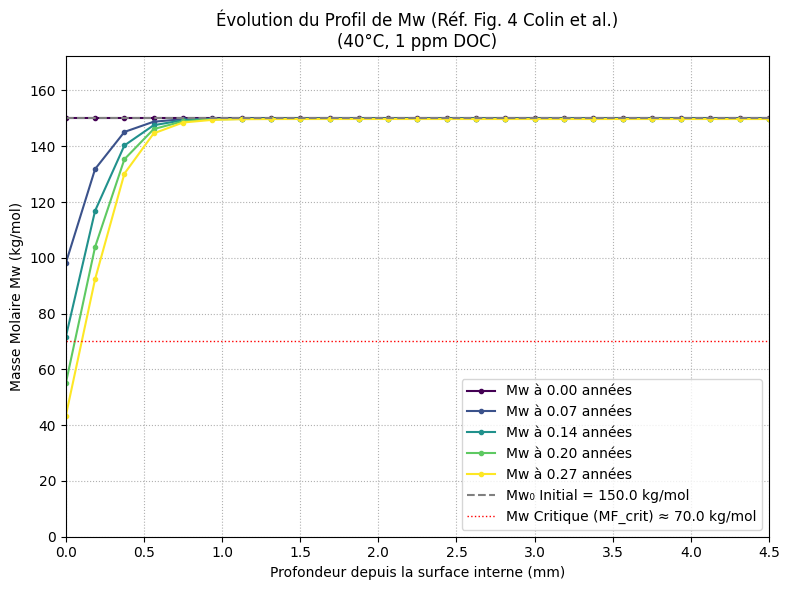


Prédiction de la durée de vie (tf) pour ce scénario (σ = 3.0 MPa)...
Note: Mw (69.46) at critical depth is already below MF (70.0) at simulation end time (0.27 years).
  Simulation de base : 99 jours d'exposition à 40°C, 1ppm DOC.
  Durée de vie résiduelle prédite (tf) : 0.03 années supplémentaires.
  Estimation de la durée de vie totale (pré-vieillissement + tf) : 0.30 années.
  (Utilisant Mw à la profondeur critique z_crit=0.1 µm)

--- Fin de la Phase 3 : Validation Mécanique (Littérature DOC) ---


In [ ]:
if __name__ == "__main__":
# Assurez-vous que les méthodes plot_mw_profile_evolution et predict_lifetime
# sont bien définies dans votre classe ColinPEDegradationModel.
    pipe_thickness_m = 4.5e-3
    num_grid_points = 25

    model = ColinPEDegradationModel2(L=pipe_thickness_m, nz=num_grid_points)

    print("\n\n--- Phase 3: Validation Mécanique (Littérature DOC) ---")
    print("Exécution d'une simulation dédiée pour l'analyse Mw et tf (basée sur Fig. 4 conditions).")

    # --- Paramètres pour la simulation de référence (DOC) ---
    # Utilisation de l'instance 'model' créée au début du __main__
    # Assurez-vous que ses paramètres L, nz, Mw0, rho, AH0_conc, ti0_oit,
    # et les paramètres mécaniques A0, H_plus_m_term etc. sont ceux
    # de référence pour le PE80/DOC de Colin et al.
    # model.ti0_oit = 165.0 (doit être déjà défini si vous avez suivi les étapes pour Fig 3)
    # ah0_multiplier_for_sample_a (calculé précédemment pour Sample A) est aussi pertinent ici.

    T_celsius_lit_mech = 40
    DOC_ppm_lit_mech = 1  # Condition de la Figure 4
    t_end_years_lit_mech = 99 / 365.25
    n_timepoints_lit_mech = 25 # Assez pour voir l'évolution et le profil final

    # Tentative avec des paramètres qui ont fonctionné pour des cas raides
    method_lit_mech = 'Radau'  # Utiliser Radau pour sa robustesse avec des systèmes raides
    rtol_lit_mech = 1e-7 # Commencez avec des tolérances un peu relaxées
    atol_lit_mech = 1e-9

    print(f"Simulation de référence : T={T_celsius_lit_mech}°C, DOC={DOC_ppm_lit_mech} ppm, Durée={t_end_years_lit_mech*365.25:.0f} jours...")
    
    # Assurez-vous que ah0_multiplier_for_sample_a est défini si vous l'avez utilisé pour Fig.3/11
    # Si ce bloc est exécuté de manière isolée, recalculez-le ou utilisez une valeur fixe.
    # Pour cet exemple, je suppose qu'il est disponible depuis les étapes précédentes.
    # Si ce n'est pas le cas:
    # ah_conc_sample_a_ref = (0.001 * (model.rho * 1000) / 1178 * model.n_AH)
    # ah0_multiplier_for_sample_a_ref = ah_conc_sample_a_ref / model.AH0_conc
    # Puis utilisez ah0_multiplier_for_sample_a_ref ci-dessous.
    # Ici, je vais supposer que 'ah0_multiplier_for_sample_a' existe déjà.

    sol_for_mw_literature = model.simulate(
        T_celsius=T_celsius_lit_mech,
        DOC_ppm=DOC_ppm_lit_mech,
        t_end_years=t_end_years_lit_mech,
        n_timepoints=n_timepoints_lit_mech,
        AH0_mult=ah0_multiplier_for_sample_a, # Assumes Sample A antioxidant level
        method=method_lit_mech,
        rtol=rtol_lit_mech,
        atol=atol_lit_mech
    )
    
    if sol_for_mw_literature and sol_for_mw_literature.success:
        print("Simulation de référence pour analyse Mw (littérature) réussie.")
        
        # 1. Plot de l'évolution du profil de Mw pour la littérature
        print("Génération du profil d'évolution de Mw (littérature)...")
        
        num_mw_profiles_to_plot = 5 
        n_timepoints_in_selected_sol = len(sol_for_mw_literature.t)
        actual_num_mw_profiles = min(num_mw_profiles_to_plot, n_timepoints_in_selected_sol)
        if actual_num_mw_profiles < 2 and n_timepoints_in_selected_sol > 0 : 
            actual_num_mw_profiles = min(2, n_timepoints_in_selected_sol)

        if n_timepoints_in_selected_sol > 0:
            indices_mw_plot_lit = np.linspace(0, n_timepoints_in_selected_sol - 1, actual_num_mw_profiles, dtype=int)
        else:
            indices_mw_plot_lit = []
            print("  La solution sélectionnée n'a pas de points temporels pour le tracé Mw.")

        if len(indices_mw_plot_lit) > 0 :
            fig_mw_evo_lit, ax_mw_evo_lit = model.plot_mw_profile_evolution(
                sol=sol_for_mw_literature,
                selected_time_indices=indices_mw_plot_lit,
                title_suffix="(Réf. Fig. 4 Colin et al.)"
            )
            if fig_mw_evo_lit:
                plt.show()
        else:
            print("  Impossible de sélectionner des points temporels pour le tracé d'évolution de Mw.")

## 2. Prédiction de tf pour la littérature
        hoop_stress_lit_MPa = 3.0 # Valeur de contrainte exemple
        print(f"\nPrédiction de la durée de vie (tf) pour ce scénario (σ = {hoop_stress_lit_MPa} MPa)...")
        
        lifetime_lit_years = model.predict_lifetime(sol_for_mw_literature, hoop_stress_MPa=hoop_stress_lit_MPa)
        
        if lifetime_lit_years is not None:
            exposure_duration_days = sol_for_mw_literature.sim_params.get('t_end_years', 0) * 365.25
            print(f"  Simulation de base : {exposure_duration_days:.0f} jours d'exposition à {sol_for_mw_literature.sim_params.get('T_celsius', '?')}°C, {sol_for_mw_literature.sim_params.get('DOC_ppm', '?')}ppm DOC.")
            print(f"  Durée de vie résiduelle prédite (tf) : {lifetime_lit_years:.2f} années supplémentaires.")
            if not np.isnan(lifetime_lit_years):
                 total_life_estimate_years = sol_for_mw_literature.sim_params.get('t_end_years', 0) + lifetime_lit_years
                 print(f"  Estimation de la durée de vie totale (pré-vieillissement + tf) : {total_life_estimate_years:.2f} années.")
            print(f"  (Utilisant Mw à la profondeur critique z_crit={model.critical_depth_m*1000:.1f} µm)")
        else:
            print("  Calcul de la durée de vie (tf) échoué ou non applicable.")
    else:
        msg = sol_for_mw_literature.message if sol_for_mw_literature else "Objet solution non créé"
        print(f"\nSimulation de référence pour analyse Mw (littérature) FAILED: {msg}")
        print("Impossible de générer les graphiques Mw et tf pour la validation littérature.")

    print("\n--- Fin de la Phase 3 : Validation Mécanique (Littérature DOC) ---")